# A notebook to capture Model Exploration and the Creation of Models

## Import the Modules needed to Run the Process

In [52]:

####--------------------------------------
#00.Import Modules
####--------------------------------------


######---------BEGIN
#      SUPPRESS DEPRECIATION WARNINGS: Applicable to datetime_is_numeric=True
######--------END

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

######---------BEGIN
#      ML
######--------END

import nltk as nl
import sklearn as sk
import matplotlib as mp
import xgboost as xg
#import pymc3 as pymc
#import sympy as sym

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


######---------BEGIN
#      SQL
######--------END


import requests as rq
import sqlalchemy as sqla
#import pyodbc
#import cx_oracle as cx


######---------BEGIN
#     GENERAL
######--------END

import pandas as pd
import datetime as dt
import numpy as np
import sys
import os
import json
import time
import socket
import traceback as tb
import platform
import json
import pprint
import pickle
import dask.dataframe as dd

######---------BEGIN
#     DATA VIS
######--------END

import seaborn as sns
import matplotlib as mp
#from bokeh import *
#from dash import *

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates


from sklearn.ensemble import RandomForestRegressor
import pickle
import joblib

In [2]:
plt.style.use('ggplot')

In [15]:
def create_xgboost_model(fulldf,train_df,test_df,target_column,plot_comp=True,plot_tree=True, threshhold_class=0.5,route_name='route102'):
    """Create an xgboostmodel"""
    
    X=fulldf.drop([target_column], axis=1)
    y=fulldf[target_column]
    
    X_test=test_df.drop([target_column], axis=1)
    y_test= test_df[target_column]
    
    X_train=train_df.drop([target_column], axis=1)
    y_train=train_df[target_column]
    
    
    #Paramter Dictionary for hypertuning
    
    model_parameters = {'nthread':[2], 
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

    #Create the XGBoost Classifier - Set loss function as logistic 
    xg_regression_model = xg.XGBRegressor(objective='reg:squarederror',verbosity = 0)
    
    #Hypertune
    grid = GridSearchCV(xg_regression_model, model_parameters)
    grid.fit(X_train, y_train)
    
    best_parameters=grid.best_params_
    xg_regression_model = grid.best_estimator_


    #Score the model
    score=xg_regression_model.score(X_train,y_train)
    print("Model Training Score: {}%".format(score*100))
    
    ###-BEGIN TESTING ON TRAIN DATA - DO NOT USE THIS, INVALID BUT REQUIRED IN Q!!!!
    
    print("---------------")
    print("---------------")
    print("As part of 3 we are meant to predict the data used to train the model (???)")
    inv_lin_prediction=xg_regression_model.predict(X_train)
    inv_linear_prediction_classified=inv_lin_prediction
    
    if plot_comp:
        #Original Versus Prediction
        print("The Original Test Vs Predicted Result for Test Set Is:")
        plt.figure(figsize=(50,20)) 
        
        #Each test is a point
        x_axis = range(len(y_train))
        plt.plot(x_axis, y_train, label="Original-Test")
        
        #Add second plot for perdiction Class
        plt.plot(x_axis, inv_linear_prediction_classified, label="Predicted-Test")
        plt.title("Test and predicted data")
        plt.legend()
        #plt.savefig('./lin_pred_vs_orig_covid.png')
        plt.show()   
    
    #Results
    inv_pred_vs_act_df=pd.DataFrame({'Actual':y_train
                                 ,'Predicted':inv_lin_prediction
                                 ,'PredictionClass':inv_linear_prediction_classified})
    
    inv_pred_vs_act_df['Predicted']=inv_pred_vs_act_df['Predicted']
    inv_pred_vs_act_df['Diff']=inv_pred_vs_act_df['Actual']-inv_pred_vs_act_df['PredictionClass']
    
    print("As required the First Ten Results predicting for the training data:")
    display(inv_pred_vs_act_df.head(10))
    
    #Metrics
    inv_model_metric=model_metrics(testActualVal=y_train, predictions=inv_linear_prediction_classified, verbose=True)
    print("---------------")
    print("---------------")
    ##---END OF CHECKING ON TRAIN DATA    
    
    
    
    
    
    
    
    #Check the predictions
    model_prediction = xg_regression_model.predict(X_test)
    
    #Classify them
    model_prediction_classified=model_prediction
    
    kfold = KFold(n_splits=5)
    results = cross_val_score(xg_regression_model, X, y, cv=kfold)
    print("Model Accuracy: {}".format(results * 100))
    
    if plot_comp:
        #Original Versus Prediction
        print("The Original Vs Predicted Result Is:")
        plt.figure(figsize=(50,20)) 
        x_axis = range(len(y_test))
        plt.plot(x_axis, y_test, label="Original")
        plt.plot(x_axis, model_prediction_classified, label="Predicted")
        plt.title("Test and predicted data")
        plt.legend()
        plt.savefig('{}_xg_pred_vs_orig.png'.format(route_name))
        plt.show()
    
    
    filename = './{}_xg_model.pickle'.format(route_name)
    
    xg_regression_model.save_model(filename)
    
    
    
        

    
    
    #Results
    pred_vs_act_df=pd.DataFrame({'Actual':y_test
                                 ,'Predicted':model_prediction
                                 ,'PredictionClass':model_prediction_classified})
    
    pred_vs_act_df['Predicted']=pred_vs_act_df['Predicted']
    pred_vs_act_df['Diff']=pred_vs_act_df['Actual']-pred_vs_act_df['PredictionClass']
    
    #Metrics
    model_metric=model_metrics(testActualVal=y_test, predictions=model_prediction_classified, verbose=True)
        
    result_dict={}
    result_dict['Model']=xg_regression_model
    result_dict['ModelType']='XGBoost'
    result_dict['RouteName']=route_name
    result_dict['Actual vs Prediction']=pred_vs_act_df
    result_dict['Model_Coefficients']=None
    result_dict['RMSE']=model_metric['RMSE']
    result_dict['MSE']=model_metric['MSE']
    result_dict['MAE']=model_metric['MAE']
    result_dict['Accuracy']=model_metric['Accuracy']
    result_dict['Confusion']=model_metric['Confusion']
    result_dict['ClassificationRep']=model_metric['ClassificationRep']
    result_dict['CrossVal_RMSE_MEAN']=np.mean(results)
    result_dict['CrossVal_RMSE_STD']=np.std(results)
    
    print("Importance by Booster Plot")
    xg.plot_importance(xg_regression_model.get_booster())
    print("Importance by Weight:")
    xg_regression_model.get_booster().get_score(importance_type='weight')
    
    
    try:
        result_dict.to_pickle("./{}_{}_ModelResultDictionary.pickle".format(route_name,result_dict['ModelType']))
    except:
        pass
        
    
    if plot_tree:
        #Visualisations, sometimes not great
        try:        

            #Tree Plot
            print("The Tree Is:")
            fig, ax = plt.subplots(figsize=(100, 100))
            xg.plot_tree(xg_regression_model,num_trees=2,ax=ax)
            plt.savefig('{}_xg_tree.png'.format(route_name))
            plt.show()

        
        
        
        except Exception as e:
            print(e)
        
    return result_dict

In [16]:
def create_logistic_model(fulldf,train_df,test_df,target_column,plot_comp, threshhold_class=0.5, assess=True, verbose=True,route_name='route102'):
    """Create a logistic model
    
    Note: Variable names say linear only as that was built first."""
    
    #Full Set
    X=fulldf.drop([target_column], axis=1)
    y=fulldf[target_column]
    
    #Test
    X_test=test_df.drop([target_column], axis=1)
    y_test= test_df[target_column]
    
    #Train
    X_train=train_df.drop([target_column], axis=1)
    y_train=train_df[target_column]
    
    
    #Create the Linear Regression
    lin_regression_model = sk.linear_model.LogisticRegression()

    #Fit the data
    lin_regression_model.fit(X_train,y_train)
    
    #--Check the coefficients--##
    coeff_statement="{} = logistic(".format(target_column)
    feature_statement="\n{}('{}' * {})"
    
    
    for feature_index in range(len(X_train.columns)):
        if feature_index==0:
            coeff_statement+=feature_statement.format('',X_train.columns[feature_index]
                                                  ,lin_regression_model.coef_[0][feature_index])
        else:
            coeff_statement+=feature_statement.format('+',X_train.columns[feature_index]
                                                  ,lin_regression_model.coef_[0][feature_index])
        
    coeff_statement+=" + ({}))\n\n\n\n".format(lin_regression_model.intercept_)
        
    if verbose:
        #Print details on the coefficients
        print(coeff_statement)

    #--End Coefficient Check--##
    
    
    ###-BEGIN TESTING ON TRAIN DATA - DO NOT USE THIS, INVALID BUT REQUIRED IN Q!!!!
    
    print("---------------")
    print("---------------")
    print("As part of 3 we are meant to predict the data used to train the model (???)")
    inv_lin_prediction=lin_regression_model.predict(X_train)
    inv_linear_prediction_classified=inv_lin_prediction
    
    if plot_comp:
        #Original Versus Prediction
        print("The Original Test Vs Predicted Result for Test Set Is:")
        plt.figure(figsize=(50,20)) 
        
        #Each test is a point
        x_axis = range(len(y_train))
        plt.plot(x_axis, y_train, label="Original-Test")
        
        #Add second plot for perdiction Class
        plt.plot(x_axis, inv_linear_prediction_classified, label="Predicted-Test")
        plt.title("Test and predicted data")
        plt.legend()
        #plt.savefig('./lin_pred_vs_orig_covid.png')
        plt.show()   
    
    #Results
    inv_pred_vs_act_df=pd.DataFrame({'Actual':y_train
                                 ,'Predicted':inv_lin_prediction
                                 ,'PredictionClass':inv_linear_prediction_classified})
    
    inv_pred_vs_act_df['Predicted']=inv_pred_vs_act_df['Predicted']
    inv_pred_vs_act_df['Diff']=inv_pred_vs_act_df['Actual']-inv_pred_vs_act_df['PredictionClass']
    
    print("As required the First Ten Results predicting for the training data:")
    display(inv_pred_vs_act_df.head(10))
    
    #Metrics
    inv_model_metric=model_metrics(testActualVal=y_train, predictions=inv_linear_prediction_classified, verbose=True)
    print("---------------")
    print("---------------")
    ##---END OF CHECKING ON TEST DATA
   
    
    
    
    
    print("---------------")
    print("---------------")
    print(" PROPER RESULT FROM TEST DATA:")
    
    
    
    
    


    
    
    
    
    
    
    
    
    #Check the predictions
    lin_prediction = lin_regression_model.predict(X_test)
    
    #Classify them - Note: Not needed for logistic but keeping as no impact
    linear_prediction_classified=lin_prediction
    
    #Plot it
    if plot_comp:
        #Original Versus Prediction
        print("Log: The Original Vs Predicted Result Is:")
        plt.figure(figsize=(50,20)) 
        
        #Each test is a point
        x_axis = range(len(y_test))
        plt.plot(x_axis, y_test, label="Original")
        
        #Add second plot for perdiction Class
        plt.plot(x_axis, linear_prediction_classified, label="Predicted")
        plt.title("COVID test and predicted data")
        plt.legend()
        plt.savefig('./{}_log_pred_vs_orig.png'.format(route_name))
        plt.show()
    
    #Save the Model
    filename = './{}_log_model.pickle'.format(route_name)
    pickle.dump(lin_regression_model, open(filename, 'wb'))
    
    
    #Results
    pred_vs_act_df=pd.DataFrame({'Actual':y_test
                                 ,'Predicted':lin_prediction
                                 ,'PredictionClass':linear_prediction_classified})
    
    pred_vs_act_df['Predicted']=pred_vs_act_df['Predicted']
    pred_vs_act_df['Diff']=pred_vs_act_df['Actual']-pred_vs_act_df['PredictionClass']
    
    #Metrics
    model_metric=model_metrics(testActualVal=y_test, predictions=linear_prediction_classified, verbose=True)
    
    
    scores = -cross_val_score(sk.linear_model.LogisticRegression(), X, y, scoring='neg_mean_squared_error', cv=5)
    print(scores)

    cv_rmse = scores**0.5
    print("Avg RMSE score over 5 folds: \n", np.mean(cv_rmse))
    print("Stddev RMSE score over 5 folds: \n", np.std(cv_rmse))
    
    
    result_dict={}
    result_dict['Model']=lin_regression_model
    result_dict['ModelType']='Logistic'
    result_dict['RouteName']=route_name
    result_dict['Model_Coefficients']=zip(X_train.columns,lin_regression_model.coef_)
    result_dict['Actual vs Prediction']=pred_vs_act_df
    result_dict['RMSE']=model_metric['RMSE']
    result_dict['MSE']=model_metric['MSE']
    result_dict['MAE']=model_metric['MAE']
    result_dict['Accuracy']=model_metric['Accuracy']
    result_dict['Confusion']=model_metric['Confusion']
    result_dict['ClassificationRep']=model_metric['ClassificationRep']
    result_dict['CrossVal_RMSE_MEAN']=np.mean(cv_rmse)
    result_dict['CrossVal_RMSE_STD']=np.std(cv_rmse)
    
    
    try:
        result_dict.to_pickle("./{}_{}_ModelResultDictionary.pickle".format(route_name,result_dict['ModelType']))
    except:
        pass
        
        
    return result_dict

In [17]:
def create_linear_model(fulldf,train_df,test_df,target_column,plot_comp, threshhold_class=0.5, assess=True, verbose=True,route_name='route102'):
    """Create a linear model"""
    
    #Full Set
    X=fulldf.drop([target_column], axis=1)
    y=fulldf[target_column]
    
    #Test
    X_test=test_df.drop([target_column], axis=1)
    y_test= test_df[target_column]
    
    #Train
    X_train=train_df.drop([target_column], axis=1)
    y_train=train_df[target_column]
    
    
    #Create the Linear Regression
    lin_regression_model = sk.linear_model.LinearRegression()

    #Fit the data
    lin_regression_model.fit(X_train,y_train)
    
    #--Check the coefficients--##
    coeff_statement="{} = ".format(target_column)
    feature_statement="\n{}('{}' * {})"
    
    
    
    for feature_index in range(len(X_train.columns)):
        if feature_index==0:
            coeff_statement+=feature_statement.format('',X_train.columns[feature_index]
                                                  ,lin_regression_model.coef_[feature_index])
        else:
            coeff_statement+=feature_statement.format('+',X_train.columns[feature_index]
                                                  ,lin_regression_model.coef_[feature_index])
        
    coeff_statement+=" + ({})\n\n\n\n".format(lin_regression_model.intercept_)
        
    if verbose:
        #Print details on the coefficients
        print(coeff_statement)

    #--End Coefficient Check--##
    
    
    ###-BEGIN TESTING ON TRAIN DATA - DO NOT USE THIS, INVALID BUT REQUIRED IN Q!!!!
    
    print("---------------")
    print("---------------")
    print("As part of 3 we are meant to predict the data used to train the model (???)")
    inv_lin_prediction=lin_regression_model.predict(X_train)
    inv_linear_prediction_classified=inv_lin_prediction
    
    if plot_comp:
        #Original Versus Prediction
        print("The Original Test Vs Predicted Result for Test Set Is:")
        plt.figure(figsize=(50,20)) 
        
        #Each test is a point
        x_axis = range(len(y_train))
        plt.plot(x_axis, y_train, label="Original-Test")
        
        #Add second plot for perdiction Class
        plt.plot(x_axis, inv_linear_prediction_classified, label="Predicted-Test")
        plt.title("Test and predicted data")
        plt.legend()
        #plt.savefig('./lin_pred_vs_orig_covid.png')
        plt.show()   
    
    #Results
    inv_pred_vs_act_df=pd.DataFrame({'Actual':y_train
                                 ,'Predicted':inv_lin_prediction
                                 ,'PredictionClass':inv_linear_prediction_classified})
    
    inv_pred_vs_act_df['Predicted']=inv_pred_vs_act_df['Predicted']
    inv_pred_vs_act_df['Diff']=inv_pred_vs_act_df['Actual']-inv_pred_vs_act_df['PredictionClass']
    
    print("As required the First Ten Results predicting for the training data:")
    display(inv_pred_vs_act_df.head(10))
    
    #Metrics
    inv_model_metric=model_metrics(testActualVal=y_train, predictions=inv_linear_prediction_classified, verbose=True)
    print("---------------")
    print("---------------")
    ##---END OF CHECKING ON TEST DATA
   
    
    
    
    
    print("---------------")
    print("---------------")
    print(" PROPER RESULT FROM TEST DATA:")
    
    
    
    
    
    
    
    #Check the predictions
    lin_prediction = lin_regression_model.predict(X_test)
    
    #Classify them
    linear_prediction_classified=lin_prediction
    
    #Plot it
    if plot_comp:
        #Original Versus Prediction
        print("The Original Vs Predicted Result Is:")
        plt.figure(figsize=(50,20)) 
        
        #Each test is a point
        x_axis = range(len(y_test))
        plt.plot(x_axis, y_test, label="Original")
        
        #Add second plot for perdiction Class
        plt.plot(x_axis, linear_prediction_classified, label="Predicted")
        plt.title("Linear test and predicted data")
        plt.legend()
        plt.savefig('./{}_lin_pred_vs_orig.png'.format(route_name))
        plt.show()
    
    #Save the Model
    filename = './{}_lin_model.pickle'.format(route_name)
    pickle.dump(lin_regression_model, open(filename, 'wb'))
    
    
    #Results
    pred_vs_act_df=pd.DataFrame({'Actual':y_test
                                 ,'Predicted':lin_prediction
                                 ,'PredictionClass':linear_prediction_classified})
    
    pred_vs_act_df['Predicted']=pred_vs_act_df['Predicted']
    pred_vs_act_df['Diff']=pred_vs_act_df['Actual']-pred_vs_act_df['PredictionClass']
    
    #Metrics
    model_metric=model_metrics(testActualVal=y_test, predictions=linear_prediction_classified, verbose=True)
    
    
    scores = -cross_val_score(sk.linear_model.LinearRegression(), X, y, scoring='neg_mean_squared_error', cv=5)
    print(scores)

    cv_rmse = scores**0.5
    print("Avg RMSE score over 5 folds: \n", np.mean(cv_rmse))
    print("Stddev RMSE score over 5 folds: \n", np.std(cv_rmse))
    
    
    result_dict={}
    result_dict['Model']=lin_regression_model
    result_dict['ModelType']='Linear'
    result_dict['RouteName']=route_name
    result_dict['Model_Coefficients']=zip(X_train.columns,lin_regression_model.coef_)
    result_dict['Actual vs Prediction']=pred_vs_act_df
    result_dict['RMSE']=model_metric['RMSE']
    result_dict['MSE']=model_metric['MSE']
    result_dict['MAE']=model_metric['MAE']
    result_dict['Accuracy']=model_metric['Accuracy']
    result_dict['Confusion']=model_metric['Confusion']
    result_dict['ClassificationRep']=model_metric['ClassificationRep']
    result_dict['CrossVal_RMSE_MEAN']=np.mean(cv_rmse)
    result_dict['CrossVal_RMSE_STD']=np.std(cv_rmse)
    
    
    try:
        result_dict.to_pickle("./{}_{}_ModelResultDictionary.pickle".format(route_name,result_dict['ModelType']))
    except:
        pass
       
        
    return result_dict

In [18]:
def create_RandomForest_model(fulldf,train_df,test_df,target_column,plot_comp, threshhold_class=0.5, assess=True, verbose=True,route_name='route102'):
    """Create a random forest model
    
    Note: The variable names say linear but that's only because it was first built for a linear model. Observe it does initialise the correct model type."""
    

    #Full Set
    X=fulldf.drop([target_column], axis=1)
    y=fulldf[target_column]
    
    #Test
    X_test=test_df.drop([target_column], axis=1)
    y_test= test_df[target_column]
    
    #Train
    X_train=train_df.drop([target_column], axis=1)
    y_train=train_df[target_column]
    
    
    #Create the DT Regression
    lin_regression_model = RandomForestRegressor(n_estimators=100, max_depth = 5, n_jobs = -1, oob_score=True, random_state=14395076)

    #Fit the data
    lin_regression_model.fit(X_train,y_train)
    

    #--End Coefficient Check--##
    ###-BEGIN TESTING ON TRAIN DATA - DO NOT USE THIS, INVALID BUT REQUIRED IN Q!!!!
    
    print("---------------")
    print("---------------")
    print("As part of 3 we are meant to predict the data used to train the model (???)")
    inv_lin_prediction=lin_regression_model.predict(X_train)
    inv_linear_prediction_classified=inv_lin_prediction
    
    if plot_comp:
        #Original Versus Prediction
        print("The Original Test Vs Predicted Result for Test Set Is:")
        plt.figure(figsize=(50,20)) 
        
        #Each test is a point
        x_axis = range(len(y_train))
        plt.plot(x_axis, y_train, label="Original-Test")
        
        #Add second plot for perdiction Class
        plt.plot(x_axis, inv_linear_prediction_classified, label="Predicted-Test")
        plt.title("Test and predicted data")
        plt.legend()
        #plt.savefig('./lin_pred_vs_orig_covid.png')
        plt.show()   
    
    #Results
    inv_pred_vs_act_df=pd.DataFrame({'Actual':y_train
                                 ,'Predicted':inv_lin_prediction
                                 ,'PredictionClass':inv_linear_prediction_classified})
    
    inv_pred_vs_act_df['Predicted']=inv_pred_vs_act_df['Predicted']
    inv_pred_vs_act_df['Diff']=inv_pred_vs_act_df['Actual']-inv_pred_vs_act_df['PredictionClass']
    
    print("As required the First Ten Results predicting for the training data:")
    display(inv_pred_vs_act_df.head(10))
    
    #Metrics
    inv_model_metric=model_metrics(testActualVal=y_train, predictions=inv_linear_prediction_classified, verbose=True)
    print("---------------")
    print("---------------")
    ##---END OF CHECKING ON TEST DATA
   
    
    
    
    
    print("---------------")
    print("---------------")
    print(" PROPER RESULT FROM TEST DATA:")
    
    
    
    
    


    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #Check the predictions
    lin_prediction = lin_regression_model.predict(X_test)
    
    #Classify them - Note: Not needed for logistic but keeping as no impact
    linear_prediction_classified=lin_prediction
    
    #Plot it
    if plot_comp:
        #Original Versus Prediction
        print("Random Forest: The Original Vs Predicted Result Is:")
        plt.figure(figsize=(50,20)) 
        
        #Each test is a point
        x_axis = range(len(y_test))
        plt.plot(x_axis, y_test, label="Original")
        
        #Add second plot for perdiction Class
        plt.plot(x_axis, linear_prediction_classified, label="Predicted")
        plt.title("Test and predicted data")
        plt.legend()
        plt.savefig('./{}_randomforest_pred_vs_orig.png'.format(route_name))
        plt.show()
    
    #Save the Model
    filename = './{}_randomforest_model.pickle'.format(route_name)
    pickle.dump(lin_regression_model, open(filename, 'wb'))
    
    feature_imp=pd.DataFrame({'feature': X_train.columns, 'importance': lin_regression_model.feature_importances_})
    feature_imp=feature_imp.set_index('feature')
    feature_imp=feature_imp.sort_values('importance', axis=0, ascending=False)
    
    if plot_comp:
        print("Random Forest: Feature Importance:")
        plt.figure(figsize=(50,20)) 
        
        #Plot from DF
        feature_imp.plot(kind='barh')
        
        #Add second plot for perdiction Class
        plt.title("Random Forest Feature Importance")
        plt.legend()
        plt.savefig('./{}_randomforest_importance.png'/format(route_name))
        plt.show()
    
    #Results
    pred_vs_act_df=pd.DataFrame({'Actual':y_test
                                 ,'Predicted':lin_prediction
                                 ,'PredictionClass':linear_prediction_classified})
    
    pred_vs_act_df['Predicted']=pred_vs_act_df['Predicted']
    pred_vs_act_df['Diff']=pred_vs_act_df['Actual']-pred_vs_act_df['PredictionClass']
    
    #Metrics
    model_metric=model_metrics(testActualVal=y_test, predictions=linear_prediction_classified, verbose=True)
    
    
    scores = cross_val_score(RandomForestRegressor(n_estimators=100, max_depth = 5, n_jobs = -1, oob_score=True, random_state=14395076), X, y, scoring='accuracy', cv=5)
    print(scores)

    cv_rmse = scores**0.5
    print("Avg Accuracy score over 5 folds: \n", np.mean(cv_rmse))
    print("Stddev Accuracy score over 5 folds: \n", np.std(cv_rmse))
    
    
    result_dict={}
    result_dict['Model']=lin_regression_model
    result_dict['ModelType']='RandomForest'
    result_dict['RouteName']=route_name
    result_dict['Model_Coefficients']=None#zip(X_train.columns,lin_regression_model.coef_)
    result_dict['Actual vs Prediction']=pred_vs_act_df
    result_dict['RMSE']=model_metric['RMSE']
    result_dict['MSE']=model_metric['MSE']
    result_dict['MAE']=model_metric['MAE']
    result_dict['Accuracy']=model_metric['Accuracy']
    result_dict['Confusion']=model_metric['Confusion']
    result_dict['ClassificationRep']=model_metric['ClassificationRep']
    result_dict['CrossVal_Acc_Mean']=np.mean(cv_rmse)
    result_dict['CrossVal_Acc_Mean']=np.std(cv_rmse)
    result_dict['FeatureImportance']=feature_imp
    
    try:
        result_dict.to_pickle("./{}_{}_ModelResultDictionary.pickle".format(route_name,result_dict['ModelType']))
    except:
        pass
    
    
    
        
    return result_dict

In [19]:
def get_test_date(df,time_column,test_set_size=0.2, verbose=False):
    """A function to determine what date should be our test date"""
    
    #Default Date - 70% of days in the year are before this.
    datetime_at_test_limit=pd.to_datetime('2018-09-13')

    sorted_datetimes=df[time_column].sort_values().unique()

    number_of_datetimes=len(sorted_datetimes)
    print("Total dates: {}".format(number_of_datetimes))

    number_of_test_dates=test_set_size*number_of_datetimes
    print("Test dates: {}".format(number_of_test_dates))

    test_index=int(number_of_datetimes - number_of_test_dates)
    print("Test index: {}".format(test_index))

    datetime_at_test_limit=sorted_datetimes[test_index]
    
    if verbose:
        print("Total dates: {}".format(number_of_datetimes))
        print("Test dates: {}".format(number_of_test_dates))
        print("Test index: {}".format(test_index))
        print("Dates after {} are test dates".format(datetime_at_test_limit))
        


    return datetime_at_test_limit


In [20]:
def get_randomised_data(df,time_column,test_size=0.3,random=False):
    """A Function to split a dataframe into a training and test set"""

    test_date=get_test_date(df=df,time_column=time_column, test_set_size=test_size, verbose=True)
    
    train=df[df[time_column] >= test_date]
    test=df[df[time_column] < test_date]
    
    split_dict={}
    split_dict['Train']=train
    split_dict['Test']=test
    
    return split_dict

In [21]:
def create_correlation_heatmap(df,pdf_fn,target_list=None,savefig=False):
    """A function to create a seaborn heatmap and save to file"""
    correlation_df = df.corr()
    
    if isinstance(target_list,list):
        correlation_df=df[df.index.isin(target_list)]
        
    plt.subplots(figsize=(50, 50))
    
    sns.heatmap(correlation_df
                , xticklabels=correlation_df.columns
                , yticklabels=correlation_df.columns
                , annot=True)
    if savefig:
        with PdfPages(pdf_fn) as pp:
            pp.savefig(plt.gcf())
            
    return correlation_df

In [22]:
#This function is used repeatedly to compute all metrics - This is from Lab 7
def model_metrics(testActualVal, predictions,verbose=True):
    #classification evaluation measures
    
    MAE=metrics.mean_absolute_error(testActualVal, predictions)
    MSE=metrics.mean_squared_error(testActualVal, predictions)
    RMSE=metrics.mean_squared_error(testActualVal, predictions)**0.5
    R2=metrics.r2_score(testActualVal, predictions)
    
    try:
        accuracy=metrics.accuracy_score(testActualVal, predictions)
    except:
        accuracy=None
        pass
    
    try:
        confusion_matrix=metrics.confusion_matrix(testActualVal, predictions)
    except:
        confusion_matrix=None
        pass
        
    try:
        classification_rep=metrics.classification_report(testActualVal, predictions,output_dict=True)
    except:
        classification_rep=None
        pass
    
    if verbose:
        print("----REPORT----")
        print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
        print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
        print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
        print("R2: ", metrics.r2_score(testActualVal, predictions))
        print("----DETAIL----")
        print("\n\nAccuracy: \n", accuracy)
        print("\n\nConfusion matrix: \n", confusion_matrix)
        print("\n\nClassification report:\n ", classification_rep)
    
    result_dict={}
    result_dict['RMSE']=RMSE
    result_dict['MAE']=MAE
    result_dict['MSE']=MSE
    result_dict['R2']=R2
    result_dict['Accuracy']=accuracy
    result_dict['Confusion']=confusion_matrix
    result_dict['ClassificationRep']=classification_rep
    
    
    
    
    return result_dict

In [23]:
def create_model(fulldf,train_df,test_df,target_column,plot_comp, threshhold_class=0.5, assess=True, verbose=True,mod_type='',route_name='route102'):
    """A wrapper to call the create model function"""
    
    if mod_type=='Linear':
        mod_result=create_linear_model(fulldf
                                    ,train_df
                                    ,test_df
                                    ,target_column
                                    ,plot_comp
                                    , threshhold_class
                                    , assess
                                    , verbose
                                    ,  route_name)
        return mod_result
    
    elif mod_type=='Logistic':
        mod_result=create_logistic_model(fulldf
                                    ,train_df
                                    ,test_df
                                    ,target_column
                                    ,plot_comp
                                    , threshhold_class
                                    , assess
                                    , verbose
                                    ,  route_name)
        return mod_result
    
    elif mod_type=='Random Forest':
        mod_result=create_RandomForest_model(fulldf
                                    ,train_df
                                    ,test_df
                                    ,target_column
                                    ,plot_comp
                                    , threshhold_class
                                    , assess
                                    , verbose
                                    , route_name)
    
        return mod_result
    
    elif mod_type=="XGBoost":
        mod_result=create_xgboost_model(fulldf
                                    ,train_df
                                    ,test_df
                                    ,target_column
                                    ,plot_comp
                                    ,threshhold_class
                                    ,route_name)
    
        return mod_result
    
    else:
        print("Sorry, I've not build that yet.")

In [66]:

def missing_check(row):
    """Highlight rows with potential missing_values"""

    #Configuration Values
    col_to_check=len(row)-1
    default_colour = 'white'
    flag_colour=''
    high_flag_colour_val='red'
    med_flag_colour_val='orange'
    low_flag_colour_val='yellow'
    val_to_check=0

    #Row length valid
    if len(row)>=col_to_check:

        #
        if row.values[col_to_check] == 'High':
            flag_colour = high_flag_colour_val
            
        elif row.values[col_to_check] == 'Medium':
            flag_colour = med_flag_colour_val
            
        elif row.values[col_to_check] == 'Low':
            flag_colour = low_flag_colour_val

        if flag_colour=='':
            colour=default_colour
        else:
            colour=flag_colour

        return ['background-color: {}'.format(colour)]*len(row.values)

    else:
        print('Row too short - Reconfigure Column Number')
        return ['background-color: {}'.format(default_colour)]*len(row.values)
    
def dt_missing_check(row):
    """Highlight rows with potential missing_values"""

    #Configuration Values
    col_to_check=len(row)-1
    default_colour = 'white'
    flag_colour=''
    high_flag_colour_val='red'
    med_flag_colour_val='orange'
    low_flag_colour_val='yellow'
    val_to_check=0

    #Row length valid
    if len(row)>=col_to_check:

        #
        if row.values[col_to_check] == 'High':
            flag_colour = high_flag_colour_val
            
        elif row.values[col_to_check] == 'Medium':
            flag_colour = med_flag_colour_val
            
        elif row.values[col_to_check] == 'Low':
            flag_colour = low_flag_colour_val

        if flag_colour=='':
            colour=default_colour
        else:
            colour=flag_colour

        return ['background-color: {}'.format(colour)]*len(row.values)

    else:
        print('Row too short - Reconfigure Column Number')
        return ['background-color: {}'.format(default_colour)]*len(row.values)
    

def ingest_data(fp,delim,data_dictionary,chunks=10000000,pandas=False, verbose=False):
    """A function to read in CSV Data and Validate.
    
    Memory error after 50M rows"""

    print("Inside ingest_data({},dictionary)".format(fp))
    
    def print_shape(raw_df):
        """A function to print the shape of a dataframe"""
        #row_column data
        shape_of_df=raw_df.shape
        row_count=shape_of_df[0]
        column_count=shape_of_df[1]

        #print info to user
        row_column_print_statement='Your file contains: \n{} rows x {} columns.\n\n'
        row_column_print_statement=row_column_print_statement.format(row_count,column_count)
        print(row_column_print_statement)
        header_statement='The following columns are present:\n'

        #print the headers
        for header in raw_df.columns:
            header_statement+='"{}"\n'.format(header)

        print(header_statement)
        return
        
    def verify_schema(raw_df,data_dictionary):
        """A function to validate the schema of a dataframe"""
        
        match=False
        #check if the schema is correct
        if set(raw_df.columns)==set(data_dictionary.keys()) and len(raw_df.columns)==len(data_dictionary.keys()):
            print('The columns in this data sample match the schema')
            match=True

        else:
            print('The columns in this data sample do not match the schema')
            
        return match
    
    def unique_values(df):
        """A function to print the unique values in each column"""
        
        print_statement="""\n\n-----\n\nColumn: {}\n\nValues: {}\n\n"""
        
        for column in df.columns:
            print_statement.format(column,df[column].unique())
            
        return

    def descriptive_stats(df,num_datetime=False):
        """A function to get descriptive stats for a dataframe"""
        
        #Format Dictionary:
        non_numeric_format_dictionary={
                              '% Populated': "{:.0f}%"
                              ,'% Missing': "{:.0f}%"
                                ,'% Top Value':"{:.0f}%"}
        
        numeric_format_dictionary={'count':"{:.0f}"
                 ,'% Populated': "{:.0f}%"
                ,'% Missing': "{:.0f}%"
                ,'% Top Value':"{:.0f}%"}




        row_count=df.shape[0]
        
        #Produce a summary table - Note the continuous features in this dataset are dates
        #Note: As of now, pandas allows using describe with dates so keeping it in, but this will be depreciated
        category_summary_df=df.describe(datetime_is_numeric=num_datetime).T

        #Add what Percent is populated
        category_summary_df['% Populated']=100*(category_summary_df['count']/row_count)

        #Percent missing
        category_summary_df['% Missing']=100-category_summary_df['% Populated']

        #Prevelance of top vlaue
        category_summary_df['% Top Value']=100*(category_summary_df['freq']/row_count)

        #Give a warning depending on quartile of missing data - upper quartiles are high
        category_summary_df['Missing Warning']=np.select([(category_summary_df['% Missing']==0),(category_summary_df['% Missing']>0) & (category_summary_df['% Missing']<25),(category_summary_df['% Missing']>=25) & (category_summary_df['% Missing']<50),category_summary_df['% Missing']>=50],['None','Low','Medium','High'])

        category_summary_df=category_summary_df.reset_index()
        category_summary_df=category_summary_df.rename(columns={"index": "feature"})

        if verbose:
            if num_datetime:
                print('Datetime: Numeric')
                display((category_summary_df.style.apply(missing_check, axis=1)
                                                     .format(non_numeric_format_dictionary)))

            else:
                print('Datetime: NotNumeric')
                display((category_summary_df.style.apply(dt_missing_check, axis=1)
                                             .format(numeric_format_dictionary)))
        
        
        return category_summary_df
        

    if pandas==True:
        #Valid Filepath
        if os.path.isfile(fp):

            raw_df = pd.DataFrame()
            chunk_count=0
            
            for chunk in pd.read_csv(fp,sep=delim,dtype=str,chunksize=chunks):
                chunk_count+=1
                print('On Chunk: {}'.format(chunk_count))
                raw_df = pd.concat([raw_df,chunk])
                
            if verbose:
                display(raw_df)

                print_shape(raw_df)

            verify_schema(raw_df,data_dictionary)
            
            if verbose:
                unique_values(raw_df)
            if verbose:
                descriptive_stats(raw_df,num_datetime=False)

            print("\n\n\nSample Data:\n\n\n")
            display(raw_df.head())
            
            return raw_df

        #Not Valid Filepath
        else:
            print("Invalid filepath - Correct the filepath and re-ingest")

            return
        
    elif pandas==False:
        
        #Valid Filepath
        if os.path.isfile(fp):

            #read_csv - Do Not Let Pandas Manipulate the Data First - Auto-assign is more memory intensive.
            raw_df=dask_df.read_csv(fp, sep=delim)
            
            if verbose:
                display(raw_df)

                print_shape(raw_df)

            verify_schema(raw_df,data_dictionary)
            
            if verbose:
                unique_values(raw_df)

            if verbose:
                descriptive_stats(raw_df,num_datetime=False)
                descriptive_stats(raw_df,num_datetime=True)
            
            print("\n\n\nSample Data:\n\n\n")
            display(raw_df.head())

            return raw_df

        #Not Valid Filepath
        else:
            print("Invalid filepath - Correct the filepath and re-ingest")

            return
        
    else:
        print('No opinion on using Dask or Pandas - Defaulting to Dask')
        
        #Valid Filepath
        if os.path.isfile(fp):

            #read_csv - Do Not Let Pandas Manipulate the Data First - Auto-assign is more memory intensive.
            raw_df=dask_df.read_csv(fp, sep=delim)
            
            if verbose:
                display(raw_df)

                print_shape(raw_df)

            verify_schema(raw_df,data_dictionary)
            
            if verbose:
                unique_values(raw_df)

                descriptive_stats(raw_df,num_datetime=False)
                descriptive_stats(raw_df,num_datetime=True)



            print("\n\n\nSample Data:\n\n\n")
            display(raw_df.head())
            
            return raw_df
        
        #Not Valid Filepath
        else:
            print("Invalid filepath - Correct the filepath and re-ingest")

            return

SyntaxError: invalid syntax (<ipython-input-66-b8f7557a8529>, line 228)

In [13]:
def classification_compare_models(model_report_list,keys):
    """A function to compare models and plot it"""
    
    comparison_df = pd.concat(model_report_list, keys=keys)
    comp_plot_df=comparison_df.reset_index()
    
    comp_plot_df=comp_plot_df.rename(columns={"level_0":"Model","level_1":"Type"})
    print("Comparison Dataframe is: \n")
    display(comp_plot_df)
    
    for column in comp_plot_df:
        if column!="Model" and column!="Type":
            
            fig = sns.factorplot(x="Type"
                                 ,y=column
                                 #,hue="Type" 
                                ,col="Model"
                                 ,data=comp_plot_df
                                 ,kind='bar')
    
            fig.set_xlabels('Type')
    
            
            fn='./model_comp_{}.png'.format(column)
            plt.savefig(fn)
            
    return comp_plot_df

In [26]:
def regression_compare_models(model_class_dictionary,keys=["Linear","Logistic","RandomForest","XGBoost"],route_name='route102'):
    """A function to compare regression models"""
    
    lin='Linear'
    log='Logistic'
    rf='RandomForest'
    xg='XGBoost'
    
    if lin in keys:
        if lin in model_class_dictionary and model_class_dictionary[lin]!='':
            linreg_class=model_class_dictionary[lin]
            
    if log in keys:
        if log in model_class_dictionary and model_class_dictionary[log]!='':
            logreg_class=model_class_dictionary[log]
            
    if rf in keys:
        if rf in model_class_dictionary and model_class_dictionary[rf]!='':
            logreg_class=model_class_dictionary[rf]
            
    if xg in keys:
        if xg in model_class_dictionary and model_class_dictionary[xg]!='':
            logreg_class=model_class_dictionary[xg]
    
    df_list=[]
    
    try:
        lin_result_dict={
        'Model':lin
        ,'Type':{'MAE':linreg_class['MAE']
                ,'RMSE':linreg_class['RMSE']
                ,'MSE':linreg_class['MSE']}
        }
        lin1_df=pd.DataFrame(lin_result_dict)
        df_list+=[lin1_df]
    except:
        pass
    
    try:
        rf_result_dict={
            'Model':rf
            ,'Type':{'MAE':rf_class['MAE']
                    ,'RMSE':rf_class['RMSE']
                    ,'MSE':rf_class['MSE']}
        }
        rf1_df=pd.DataFrame(rf_result_dict)
        df_list+=[rf1_df]
    except:
        pass

    try:
        xgb_result_dict={
            'Model':xg
            ,'Type':{'MAE':xgb_class['MAE']
                    ,'RMSE':xgb_class['RMSE']
                    ,'MSE':xgb_class['MSE']}
        }
        xg1_df=pd.DataFrame(xgb_result_dict)
        df_list+=[xg1_df]
        
    except:
        pass
    
    try:
        log_result_dict={
            'Model':log
            ,'Type':{'MAE':log_class['MAE']
                    ,'RMSE':log_class['RMSE']
                    ,'MSE':log_class['MSE']}
        }
        log1_df=pd.DataFrame(log_result_dict)
        df_list+=[log1_df]
        
        
    except:
        pass
    
    if len(df_list)>0:
        first_df=df_list[0]
        concat_result_df=first_df

        for df in df_list[1:]:
            concat_result_df=concat_result_df.append(df)

        concat_result_df=concat_result_df.reset_index()
        display(concat_result_df)
        concat_result_df=concat_result_df.rename(columns={"index": "Metric",'Type':'Value'})
            
        unique_metrics=concat_result_df['Metric'].unique()
        
        for metric in ['MSE']:
            non_metric_df=concat_result_df[concat_result_df['Metric']!=metric]
            metric_df=concat_result_df[concat_result_df['Metric']==metric]
                
            for column in metric_df:
                if column!="Model" and column!="Metric":

                    fig = sns.catplot(x="Metric"
                                         ,y="Value"
                                         #,hue="Type" 
                                        ,col="Model"
                                         ,data=metric_df
                                         ,kind='bar')

                    fig.set_xlabels(metric)


                    fn='./{}_model_comp_{}_{}.png'.format(route_name,metric,column)
                    plt.savefig(fn)
        
            for column in non_metric_df:
                if column!="Model" and column!="Metric":

                    fig = sns.catplot(x="Metric"
                                         ,y="Value"
                                         #,hue="Type" 
                                        ,col="Model"
                                         ,data=non_metric_df
                                         ,kind='bar')

                    fig.set_xlabels('Metric')


                    fn='./{}_model_comp_non{}_{}.png'.format(route_name,metric,column)
                    plt.savefig(fn)

        return concat_result_df
    
    return pd.DataFrame()

In [27]:
def holiday(df,feature='DAYOFSERVICE'):
    holiday = [6,7,8, 12]
    if df[feature].month in holiday:
        return 1
    elif df[feature].month == 3 and df[feature].day == 17:
        return 1
    elif df[feature].month == 1 and df[feature].day == 1:
        return 1
    elif df[feature].month == 5 and df[feature].day == 1:
        return 1
    else:
        return 0

In [28]:
def data_convert(df,types,columnlist,dt_format):
    """A function to convert all columns in a list into the appropriate type"""
    
    print("Inside data_convert()")
    
    ###Check if empty
    if len(df.index) != 0:
        
        ##Check if datetime or other
        if types=='datetime':
       
            ###Check if 0
            if len(columnlist)>0:
                print('Converting to {}'.format(types))
                
                for column in columnlist:
                    df[column]=df[column].apply(pd.to_datetime,format=dt_format,errors='ignore')
                
            else:
                print('No need to convert to: {}'.format(types))
              
        ###Numeric type
        elif types=='category':
            ###Check if 0
            if len(columnlist)>0:
                print('Converting to {}'.format(types))
                
                for column in columnlist:
                    df[column]=df[column].astype('category')
                
            ###Nothing to convert
            else:
                print('No need to convert')
                
        ###Numeric type
        elif types=='numeric':
            
            ###Check if 0
            if len(columnlist)>0:
                print('Converting to Numerical')
                
                for column in columnlist:
                    df[column]=df[column].apply(pd.to_numeric, errors='ignore')
                
            else:
                print('No need to convert')
                
        ###Other type - e.g. Boolean, string - Dont do anything - force the above types.
        else:
            print('Unknown type')
                
    ###Empty data set          
    else:
        print("Empty dataframe")

In [29]:
# reading the data of a dask directory and converting into a pandas dataframe
def read_dd_to_pandas(route):
    route_dask_df = dd.read_csv("~/data/leavetimes_split_by_route/{}/*.part".format(route))
    route_dask_df = route_dask_df.drop('Unnamed: 0', axis=1)
    route_pd_df = route_dask_df.compute()
    route_pd_df = route_pd_df.reset_index(drop=True)
    route_pd_df["DAYOFSERVICE"] = pd.to_datetime(route_pd_df["DAYOFSERVICE"])
    route_pd_df["LASTUPDATE"] = pd.to_datetime(route_pd_df["LASTUPDATE"])
    return route_pd_df

In [30]:

# create mapping function
def seconds_to_time(n):
    return dt.timedelta(seconds=n)



In [31]:
def dask_to_csv(fp='~/data/leavetimes_split_by_route/',route='route102'):
    """A funtion to convert a Dask File to a CSV"""
    route_pd_df = read_dd_to_pandas(route)
    print(route_pd_df.columns)
    route_pd_df.to_csv("~/data/leavetimes_split_by_route/{}.csv".format(route),index=False)
    print(type(route_pd_df))
    return "Complete"

In [32]:
def flag_outlier(df,column_to_flag='delay_amount',outlier_limit=1800):
    """A function to flag outliers"""
    
    df.loc[(abs(df[column_to_flag]) > outlier_limit),'outlier_flag']=1
    df.loc[(abs(df[column_to_flag]) <= outlier_limit),'outlier_flag']=0
    
    return df

In [33]:
def flag_holiday(df, column_to_flag='DAYOFSERVICE'):
    
    df["holiday"] = df.apply(holiday, axis = 1)
    
    return df

In [34]:
def add_day_of_week(df,column_to_addfrom='DAYOFSERVICE'):
    """A function to add the day of the week"""
    df["day_of_week"] = df["DAYOFSERVICE"].dt.day_name()
    return df
    

In [35]:
def add_time_features(df, date_time_column='DAYOFSERVICE'):
    """
    Various time features for analytics
    """
    print(df)
    #Features to keep
    #df['timestamp']=(df[date_time_column].astype(int)/10**9).astype(int)
    df['new_hour'] = df[date_time_column].dt.hour
    df['new_dayofweek'] = df[date_time_column].dt.dayofweek
    df['new_dayofmonth'] = df[date_time_column].dt.day
    df['new_dayofyear'] = df[date_time_column].dt.dayofyear
    
    df['bool_weekend']=np.where(df['new_dayofweek']>4, True, False)
    #df['bool_level5']=np.where(df['dayofyear']<pd.to_datetime('2021-05-04').dt.day, True, False)
    
    #Bank Holidays and weekend
    df['bool_dayoff']=False
    
    df.loc[(df['new_dayofweek']>4),'bool_dayoff'] = True
    
    #Work Hours 9am to 5pm
    df['bool_workhour']=True
    df.loc[(df['new_hour']>8) &
            (df['new_hour']<16),'bool_workhour']=False
    
    df['bool_commutehour']=False
    df.loc[((df['new_hour']>=7) & (df['new_hour']<=8)) |
           ((df['new_hour']>=16) & (df['new_hour']<=17)),'bool_commutehour']= True
       
    #9pm - 5am
    df['bool_night']=False
    df.loc[(df['new_hour']>20) | 
            (df['new_hour']<6),'bool_night']=True
                        
    #Poor Results:
    #df['quarter'] = df[date_time_column].dt.quarter
    df['new_month'] = df[date_time_column].dt.month
    df['new_year'] = df[date_time_column].dt.year
    df['new_minute'] = df[date_time_column].dt.minute
    #df['weekofyear'] = df[date_time_column].dt.weekofyear
    #df=d#f.drop(date_time_column, axis=1)

    df=df.drop('new_dayofyear',axis=1)
    
    return [df,['new_minute','new_hour','new_dayofweek','new_dayofmonth','new_month','new_year','bool_weekend','bool_dayoff','bool_workhour','bool_commutehour','bool_night']]

In [36]:
def add_actual_planned_arrival_times(df,planned_column='PLANNEDTIME_ARR',actual_column='ACTUALTIME_ARR',column_to_addfrom='DAYOFSERVICE'):
    
    route_time_planned = df[planned_column]
    route_time_actual = df[actual_column]

    actual_time_hour = []
    expected_time_hour = []
    for i in range(len(route_time_actual)):
        actual_time_hour.append(route_time_actual[i] // 3600)
        expected_time_hour.append(route_time_planned[i] // 3600)

    actual_date = pd.to_datetime(df[column_to_addfrom])


    # parse it into datetime with this  any hours
    date_time = []
    for i in range(len(actual_time_hour)):
        new_datetime = actual_date[i] + dt.timedelta(hours = int(actual_time_hour[i]))
        date_time.append(new_datetime)

    # add in the new column, 
    # new column means that we can remove the other date column
    df["date_and_time"] = date_time
    df["datetime_exact"] = df[column_to_addfrom] + pd.Series(map(seconds_to_time, df[planned_column]), name="time")

    df["delay_amount"] = df[actual_column] - df[planned_column]

    #combined_df["planned_hour_arr"]
    hours = df[planned_column]//3600
    #combined_df["planned_minute_arr"]

    minutes= (df[actual_column]%3600) // 60

    df["planned_arr_hours"] = hours
    df["planned_arr_minutes"] = minutes
    
    return df

In [37]:
def chart_by_timefeatures(df,target_feature='delay_amount',route_name='route102',save_fig=True):

    is_night_df=df[df['bool_night']==True]
    isnt_night_df=df[df['bool_night']==False]

    is_monday=df[df['new_dayofweek']==0]
    is_tuesday=df[df['new_dayofweek']==1]
    is_wednesday=df[df['new_dayofweek']==2]
    is_thursday=df[df['new_dayofweek']==3]
    is_friday=df[df['new_dayofweek']==4]
    is_saturday=df[df['new_dayofweek']==5]
    is_sunday=df[df['new_dayofweek']==6]


    is_weekend=df[df['bool_weekend']==True]
    isnt_weekend=df[df['bool_weekend']==False]


    is_commute=df[df['bool_commutehour']==True]
    isnt_commute=df[df['bool_commutehour']==False]
    
    is_monday.groupby(['new_hour'])[target_feature].mean().plot()
    is_tuesday.groupby(['new_hour'])[target_feature].mean().plot()
    is_wednesday.groupby(['new_hour'])[target_feature].mean().plot()
    is_thursday.groupby(['new_hour'])[target_feature].mean().plot()
    is_friday.groupby(['new_hour'])[target_feature].mean().plot()
    is_saturday.groupby(['new_hour'])[target_feature].mean().plot()
    is_sunday.groupby(['new_hour'])[target_feature].mean().plot()
    plt.title('Average Delay Time by Hour By Day')
    plt.ylabel('Averge Delay Time Per Hour')
    plt.legend(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'],fontsize = 'small')
    
    if save_fig:
        plt.savefig('./{}_by_day.png'.format(route_name))
        
    plt.show()

    is_weekend.groupby(['new_hour'])[target_feature].mean().plot()
    isnt_weekend.groupby(['new_hour'])[target_feature].mean().plot()
    plt.title('Average Delay Time by Hour By Weekend vs Weekday')
    plt.ylabel('Delay Time Per Hour')
    plt.legend(['Weekend','Not Weekend'],fontsize = 'small')
    if save_fig:
        plt.savefig('./{}_by_WeekendorWeekday.png'.format(route_name))
    plt.show()


    is_night_df.groupby(['new_hour'])[target_feature].mean().plot()
    isnt_night_df.groupby(['new_hour'])[target_feature].mean().plot()
    plt.title('Average Delay Time by Day/Night')
    plt.ylabel('Delay Time Per Hour')
    plt.legend(['Night','Not Night'],fontsize = 'small')
    if save_fig:
        plt.savefig('./{}_by_NightOrNotNight.png'.format(route_name))
    plt.show()


    is_commute.groupby(['new_hour'])[target_feature].mean().plot()
    isnt_commute.groupby(['new_hour'])[target_feature].mean().plot()
    plt.title('Average Delay Time by Commute Time')
    plt.ylabel('Delay Time Per Hour')
    plt.legend(['Commute Hour','Not Commute Hour'],fontsize = 'small')
    if save_fig:
        plt.savefig('./{}_by_CommuteHour.png'.format(route_name))
    plt.show()

In [38]:
def join_weather_to_route_df(route_df,weather_df):
    """Join Weather to Route"""
    enhanced_weather_df=add_time_features(df=weather_df, date_time_column='dt')
    enhanced_weather_df=enhanced_weather_df[0]
    enhanced_weather_df=enhanced_weather_df[enhanced_weather_df['new_year']==2018]
    
    display(enhanced_weather_df)
    print(enhanced_weather_df.columns)
    
    total_df = pd.merge(route_df, enhanced_weather_df, left_on = ["new_hour",'new_dayofmonth','new_month'], right_on = ["new_hour",'new_dayofmonth','new_month'])
    
    
    return total_df

In [39]:
def join_trip_to_route_df(df,trip_fp="./data/rt_trips_DB_2018.txt",trip_sep=';'):
    """Add Trip to Route
    
    One tripId might be present for multiple days so need to join on day of service"""
    
    trips_df = pd.read_csv(trip_fp, sep = ";")
    
    trips_df['TRIPID']=trips_df['TRIPID'].astype('str')
    trips_df['LINEID']=trips_df['LINEID'].astype('category')
    trips_df['DIRECTION']=trips_df['DIRECTION'].astype('category')
    trips_df['ROUTEID']=trips_df['ROUTEID'].astype('category')
    trips_df['DAYOFSERVICE']=pd.to_datetime(trips_df['DAYOFSERVICE'])
    
    print(trips_df.dtypes)
    
    trips_direction_df = trips_df[["LINEID","ROUTEID","TRIPID", "DIRECTION",'DAYOFSERVICE']]
    
    join_df = pd.merge(df ,trips_direction_df,left_on=['TRIPID','DAYOFSERVICE'],right_on=['TRIPID','DAYOFSERVICE'], how='inner') 
    
    return join_df

In [60]:
def generate_csvs_for_route(directory='data/leavetimes_split_by_route',verbose=False,overwrite=False):
    """Generate CSVs for Each Route"""
    
    for filename in os.listdir(directory):
        
        csv_files=[filename.replace(".csv","") for filename in os.listdir(directory) if filename[-3::]=='csv']
        csv_files+=[filename for filename in os.listdir(directory) if filename[-3::]=='csv']
        
        if overwrite==False:
            
            if filename not in csv_files and filename[-3::]!='csv':
                            
                if verbose:
                    print('------------------')
                    print('Generating: {}'.format(filename))
                    print('------------------')

                try:
                    route_name = filename
                    dask_to_csv(fp='./data/leavetimes_split_by_route/',route=route_name)

                except Exception as e:
                    print('{} - {}'.format(route_name,e))
                    continue
         
        else:
            if filename[-3::]!='csv':

                if verbose:
                    print('------------------')
                    print('Generating: {}'.format(filename))
                    print('------------------')

                try:
                    route_name = filename
                    dask_to_csv(fp='./data/leavetimes_split_by_route/',route=route_name)

                except Exception as e:
                    print('{} - {}'.format(route_name,e))
                    continue
    
    return 'Finished'

In [ ]:
def add_all_features(route_df,planned_column='PLANNEDTIME_ARR',actual_column='ACTUALTIME_ARR',column_to_addfrom='DAYOFSERVICE',column_to_flag='delay_amount',date_time_column='date_and_time',outlier_limit=1800):
    """Add all features to the df"""
    route_pd_df=add_actual_planned_arrival_times(df=route_df
                                                 ,planned_column=planned_column,
                                                 actual_column=actual_column,
                                                 column_to_addfrom=column_to_addfrom)

    # get the day of the week form the 
    route_pd_df=add_day_of_week(df=route_pd_df
                                ,column_to_addfrom=column_to_addfrom)

    route_pd_df=flag_holiday(df=route_pd_df
                             , column_to_flag=column_to_addfrom)

    route_pd_df=flag_outlier(df=route_pd_df
                             ,column_to_flag=column_to_flag
                             ,outlier_limit=outlier_limit)


    route_pd_df=flag_outlier(df=route_pd_df
                             ,column_to_flag=column_to_flag
                             ,outlier_limit=outlier_limit)

    route_pd_df=add_time_features(df=route_pd_df
                                  , date_time_column=date_time_column)[0]
    
    return route_pd_df

In [58]:
generate_csvs_for_route(directory='data/leavetimes_split_by_route')

Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID',

<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',

<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',

<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',

<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',

'Finished'

In [63]:
def import_weather(datetime_format='YYYY-MM-DD'):
    """Weather"""
    
    weather_fp="./data/openweatherapi_2018_data_with_columns_removed2021-06-26 01:55:47.555341.csv"
    weather_data_dictionary={'dt':['Date','datetime']
                             , 'dt_iso':['Date','datetime']
                             , 'timezone':['Date','category']
                             , 'temp':['Date','numeric']
                             , 'feels_like':['Date','numeric']
                             , 'temp_min':['Date','numeric']
                             ,'temp_max':['Date','numeric']
                             , 'pressure':['Date','numeric']
                             , 'humidity':['Date','numeric']
                             , 'wind_speed':['Date','numeric']
                             , 'wind_deg':['Date','numeric']
                             , 'rain_1h':['Date','numeric']
                             , 'snow_1h':['Date','numeric']
                             , 'clouds_all':['Date','category']
                             , 'weather_id':['Date','category']
                             , 'weather_main':['Date','category']
                             , 'weather_description':['Date','category']
                             , 'weather_icon':['Date','category']}

    weather_df = ingest_data(fp=weather_fp,delim=',',data_dictionary=weather_data_dictionary,chunks=10000000,pandas=True)
    weather_df["dt"] = pd.to_datetime(weather_df["dt"]).dt.tz_localize(None)

    weather_datetime_columns=[column_headers for column_headers, column_desc_array in weather_data_dictionary.items() if column_desc_array[1] == 'datetime']
    weather_categorical_columns=[column_headers for column_headers, column_desc_array in weather_data_dictionary.items() if column_desc_array[1] == 'category']
    weather_num_columns=[column_headers for column_headers, column_desc_array in weather_data_dictionary.items() if column_desc_array[1] in ('numeric','int64','float64')]


    data_convert(weather_df,'category',weather_categorical_columns,datetime_format)
    data_convert(weather_df,'numeric',weather_num_columns,datetime_format)
    
    return weather_df

In [65]:
def save_full_processed_data(directory='data/leavetimes_split_by_route'):
    """A function to save all of the routes to pickle fully formatted."""
    
    weather_df=import_weather()
        
    route_data_dictionary={
                            'DAYOFSERVICE':['Description','datetime']
                            , 'TRIPID':['Description','category']
                            , 'PROGRNUMBER':['Description','category']
                            , 'STOPPOINTID':['Description','category']
                            ,'PLANNEDTIME_ARR':['Description','numeric']
                            , 'PLANNEDTIME_DEP':['Description','numeric']
                            , 'ACTUALTIME_ARR':['Description','numeric']
                            ,'ACTUALTIME_DEP':['Description','numeric']
                            , 'VEHICLEID':['Description','category']
                            , 'SUPPRESSED':['Description','category']
                            , 'JUSTIFICATIONID':['Description','datetime']
                            ,'LASTUPDATE':['Description','datetime']
                        }
    
    correlation_columns=['DAYOFSERVICE'
                         , 'TRIPID'
                         , 'PROGRNUMBER'
                         , 'STOPPOINTID'
                         , 'PLANNEDTIME_ARR'
                         , 'PLANNEDTIME_DEP'
                         , 'ACTUALTIME_ARR'
                         , 'ACTUALTIME_DEP'
                         , 'VEHICLEID'
                         , 'SUPPRESSED'
                         , 'JUSTIFICATIONID'
                         , 'LASTUPDATE'
                         , 'date_and_time'
                         , 'datetime_exact'
                         , 'delay_amount'
                         , 'planned_arr_hours'
                         , 'planned_arr_minutes'
                         , 'day_of_week'
                         , 'holiday'
                         , 'outlier_flag'
                         , 'new_hour'
                         , 'new_dayofweek_x'
                         , 'new_dayofmonth'
                         , 'bool_weekend_x'
                         , 'bool_dayoff_x'
                         , 'bool_workhour_x'
                         , 'bool_commutehour_x'
                         , 'bool_night_x'
                         , 'new_month'
                         , 'LINEID'
                         , 'ROUTEID'
                         , 'DIRECTION'
                         , 'dt'
                         , 'dt_iso'
                         , 'timezone'
                         , 'temp'
                         , 'feels_like'
                         , 'temp_min'
                         , 'temp_max'
                         , 'pressure'
                         , 'humidity'
                         , 'wind_speed'
                         , 'wind_deg'
                         , 'rain_1h'
                         , 'snow_1h'
                         , 'clouds_all'
                         , 'weather_id'
                         , 'weather_main'
                         , 'weather_description'
                         , 'weather_icon']
    
    datetime_format='YYYY-MM-DD HH:MM:SS'
    
    target_feature='delay_amount'

    route_datetime_columns=[column_headers for column_headers, column_desc_array in route_data_dictionary.items() if column_desc_array[1] == 'datetime']
    route_categorical_columns=[column_headers for column_headers, column_desc_array in route_data_dictionary.items() if column_desc_array[1] == 'category']
    route_num_columns=[column_headers for column_headers, column_desc_array in route_data_dictionary.items() if column_desc_array[1] in ('numeric','int64','float64')]


    
    for filename in os.listdir(directory):
        csv_routes=[filename.replace(".csv","") for filename in os.listdir(directory) if filename[-3::]=='csv']
        
    for route in csv_routes:
        
        try:
            route_name=route
            csv_route_to_analyse_fp='./data/leavetimes_split_by_route/{}.csv'.format(route)

            route_df=ingest_data(fp=csv_route_to_analyse_fp,delim=',',data_dictionary=route_data_dictionary,chunks=10000000,pandas=True)

            try:
                route_df["DAYOFSERVICE"]=pd.to_datetime(route_df["DAYOFSERVICE"])
                route_df["LASTUPDATE"]=pd.to_datetime(route_df["LASTUPDATE"])
            except:
                pass

            data_convert(route_df,'category',route_categorical_columns,datetime_format)
            data_convert(route_df,'numeric',route_num_columns,datetime_format)

            route_pd_df=add_all_features(route_df
                                         ,planned_column='PLANNEDTIME_ARR'
                                         ,actual_column='ACTUALTIME_ARR'
                                         ,column_to_addfrom='DAYOFSERVICE'
                                         ,column_to_flag=target_feature
                                         ,date_time_column='date_and_time'
                                         ,outlier_limit=1800)


            chart_by_timefeatures(df=route_pd_df
                                  ,target_feature=target_feature
                                  ,route_name=route_name
                                  ,save_fig=True)

            route_pd_df.drop(['new_minute','new_year'],axis=1,inplace=True)

            train_correlation_df=create_correlation_heatmap(df=route_pd_df
                                                    ,pdf_fn='./1_{}_Correlation_Heatmap_NoWeather.pdf'.format(route_name)
                                                    ,savefig=True)

            merged_df=join_trip_to_route_df(df=route_pd_df,trip_fp="./data/rt_trips_DB_2018.txt",trip_sep=';')
            print("""Does the row count match: {} = {}? {}""".format(len(route_pd_df),len(merged_df),len(route_pd_df)==len(merged_df)))

            total_df=join_weather_to_route_df(route_df=merged_df,weather_df=weather_df)

            total_df=total_df.drop_duplicates(["TRIPID", "datetime_exact"])

            try:
                total_df=total_df[correlation_columns]

            except:
                pass

            full_df=total_df[total_df['outlier_flag']==0]
            full_df.to_pickle("./data/{}_full_df.pickle".format(route_name))
            
            if os.path.exists(csv_route_to_analyse_fp):
                os.remove(csv_route_to_analyse_fp)
            
            
        except Exception as route_except:
            print("{} - {}".format(route_name,route_except))
        
    return

In [67]:
save_full_processed_data(directory='data/leavetimes_split_by_route')

Inside ingest_data(./data/openweatherapi_2018_data_with_columns_removed2021-06-26 01:55:47.555341.csv,dictionary)
On Chunk: 1


,dt,dt_iso,timezone,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2017-12-31 00:00:00,2017-12-31 00:00:00 +0000 UTC,0,283.06,279.56,281.15,285.15,983,93,4.63,140,0.0,NaN,75,803,Clouds,broken clouds,04n
1,2017-12-31 01:00:00,2017-12-31 01:00:00 +0000 UTC,0,284.24,274.44,284.15,284.716,983,82,13.38,230,0.0,NaN,75,803,Clouds,broken clouds,04n
2,2017-12-31 02:00:00,2017-12-31 02:00:00 +0000 UTC,0,284.16,275.52,283.66200000000003,284.66900000000004,982,76,11.32,220,0.0,NaN,75,803,Clouds,broken clouds,04n
3,2017-12-31 03:00:00,2017-12-31 03:00:00 +0000 UTC,0,283.14,271.2,282.423,283.726,983,62,14.92,240,0.0,NaN,75,803,Clouds,broken clouds,04n
4,2017-12-31 04:00:00,2017-12-31 04:00:00 +0000 UTC,0,281.75,268.11,281.15,282.742,984,61,16.98,240,0.0,NaN,75,803,Clouds,broken clouds,04n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8843,2019-01-01 19:00:00,2019-01-01 19:00:00 +0000 UTC,0,279.47,276.71,278.15,281.333,1040,86,2.1,10,0.0,NaN,75,803,Clouds,broken clouds,04n
8844,2019-01-01 20:00:00,2019-01-01 20:00:00 +0000 UTC,0,279.21,275.7,278.15,280.829,1041,86,3.1,360,0.0,NaN,75,803,Clouds,broken clouds,04n
8845,2019-01-01 21:00:00,2019-01-01 21:00:00 +0000 UTC,0,278.05,274.69,275.93,280.35400000000004,1040,86,2.6,20,0.0,NaN,75,803,Clouds,broken clouds,04n
8846,2019-01-01 22:00:00,2019-01-01 22:00:00 +0000 UTC,0,277.36,274.84,275.15,280.141,1041,93,1.5,0,0.0,NaN,75,803,Clouds,broken clouds,04n


Your file contains: 
8848 rows x 18 columns.


The following columns are present:
"dt"
"dt_iso"
"timezone"
"temp"
"feels_like"
"temp_min"
"temp_max"
"pressure"
"humidity"
"wind_speed"
"wind_deg"
"rain_1h"
"snow_1h"
"clouds_all"
"weather_id"
"weather_main"
"weather_description"
"weather_icon"

The columns in this data sample match the schema
Datetime: NotNumeric


,feature,count,unique,top,freq,% Populated,% Missing,% Top Value,Missing Warning
0,dt,8848,8808,2018-12-17 21:00:00,2,100%,0%,0%,None
1,dt_iso,8848,8808,2018-12-23 05:00:00 +0000 UTC,2,100%,0%,0%,None
2,timezone,8848,2,3600,5219,100%,0%,59%,None
3,temp,8848,2181,280.16,30,100%,0%,0%,None
4,feels_like,8848,2713,275.54,14,100%,0%,0%,None
5,temp_min,8848,5119,279.15,240,100%,0%,3%,None
6,temp_max,8848,4261,289.15,305,100%,0%,3%,None
7,pressure,8848,63,1017,401,100%,0%,5%,None
8,humidity,8848,64,93,1273,100%,0%,14%,None
9,wind_speed,8848,105,3.6,773,100%,0%,9%,None





Sample Data:





,dt,dt_iso,timezone,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2017-12-31 00:00:00,2017-12-31 00:00:00 +0000 UTC,0,283.06,279.56,281.15,285.15,983,93,4.63,140,0.0,NaN,75,803,Clouds,broken clouds,04n
1,2017-12-31 01:00:00,2017-12-31 01:00:00 +0000 UTC,0,284.24,274.44,284.15,284.716,983,82,13.38,230,0.0,NaN,75,803,Clouds,broken clouds,04n
2,2017-12-31 02:00:00,2017-12-31 02:00:00 +0000 UTC,0,284.16,275.52,283.66200000000003,284.66900000000004,982,76,11.32,220,0.0,NaN,75,803,Clouds,broken clouds,04n
3,2017-12-31 03:00:00,2017-12-31 03:00:00 +0000 UTC,0,283.14,271.2,282.423,283.726,983,62,14.92,240,0.0,NaN,75,803,Clouds,broken clouds,04n
4,2017-12-31 04:00:00,2017-12-31 04:00:00 +0000 UTC,0,281.75,268.11,281.15,282.742,984,61,16.98,240,0.0,NaN,75,803,Clouds,broken clouds,04n


Inside data_convert()
Converting to category
Inside data_convert()
Converting to Numerical
Inside ingest_data(./data/leavetimes_split_by_route/route27X.csv,dictionary)
On Chunk: 1


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE
0,2018-01-02,5967287,47,4594,65715,65715,64942,64942,2693260,NaN,NaN,2018-01-09 20:18:05
1,2018-01-02,5967287,46,4593,65546,65546,64760,64773,2693260,NaN,NaN,2018-01-09 20:18:05
2,2018-01-02,5967287,44,6115,65419,65419,64645,64660,2693260,NaN,NaN,2018-01-09 20:18:05
3,2018-01-02,5967287,42,1269,65304,65304,64529,64529,2693260,NaN,NaN,2018-01-09 20:18:05
4,2018-01-02,5967287,41,1268,65257,65257,64487,64497,2693260,NaN,NaN,2018-01-09 20:18:05
...,...,...,...,...,...,...,...,...,...,...,...,...
41453,2018-12-17,8463881,31,302,31276,31276,31858,31892,1932324,NaN,NaN,2018-12-27 08:21:23
41454,2018-12-17,8463881,44,2089,32523,32523,33397,33397,1932324,NaN,NaN,2018-12-27 08:21:23
41455,2018-12-17,8463880,10,4692,27686,27686,27793,27793,2406920,NaN,NaN,2018-12-27 08:21:23
41456,2018-12-17,8463880,19,1248,28015,28015,28138,28154,2406920,NaN,NaN,2018-12-27 08:21:23


Your file contains: 
41458 rows x 12 columns.


The following columns are present:
"DAYOFSERVICE"
"TRIPID"
"PROGRNUMBER"
"STOPPOINTID"
"PLANNEDTIME_ARR"
"PLANNEDTIME_DEP"
"ACTUALTIME_ARR"
"ACTUALTIME_DEP"
"VEHICLEID"
"SUPPRESSED"
"JUSTIFICATIONID"
"LASTUPDATE"

The columns in this data sample match the schema
Datetime: NotNumeric


,feature,count,unique,top,freq,% Populated,% Missing,% Top Value,Missing Warning
0,DAYOFSERVICE,41458,244,2018-01-19,184,100%,0%,0%,None
1,TRIPID,41458,168,7325711,857,100%,0%,2%,None
2,PROGRNUMBER,41458,47,28,918,100%,0%,2%,None
3,STOPPOINTID,41458,92,4952,897,100%,0%,2%,None
4,PLANNEDTIME_ARR,41458,3909,29100,239,100%,0%,1%,None
5,PLANNEDTIME_DEP,41458,3909,29100,239,100%,0%,1%,None
6,ACTUALTIME_ARR,41458,11921,27779,14,100%,0%,0%,None
7,ACTUALTIME_DEP,41458,11894,29653,14,100%,0%,0%,None
8,VEHICLEID,41458,69,2868355,1750,100%,0%,4%,None
9,SUPPRESSED,106,1,0.0,106,0%,100%,0%,High





Sample Data:





,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE
0,2018-01-02,5967287,47,4594,65715,65715,64942,64942,2693260,NaN,NaN,2018-01-09 20:18:05
1,2018-01-02,5967287,46,4593,65546,65546,64760,64773,2693260,NaN,NaN,2018-01-09 20:18:05
2,2018-01-02,5967287,44,6115,65419,65419,64645,64660,2693260,NaN,NaN,2018-01-09 20:18:05
3,2018-01-02,5967287,42,1269,65304,65304,64529,64529,2693260,NaN,NaN,2018-01-09 20:18:05
4,2018-01-02,5967287,41,1268,65257,65257,64487,64497,2693260,NaN,NaN,2018-01-09 20:18:05


Inside data_convert()
Converting to category
Inside data_convert()
Converting to Numerical
route27X - name 'add_all_features' is not defined
Inside ingest_data(./data/leavetimes_split_by_route/route27A.csv,dictionary)
On Chunk: 1


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE
0,2018-01-01,5960833,15,645,60807,60807,60641,60641,2868406,NaN,NaN,2018-01-08 17:21:10
1,2018-01-01,5958707,15,645,52749,52749,52596,52596,2406920,NaN,NaN,2018-01-08 17:21:10
2,2018-01-01,5960831,15,645,55449,55449,55448,55448,2868406,NaN,NaN,2018-01-08 17:21:10
3,2018-01-01,5958713,15,645,68879,68879,68862,68875,2406920,NaN,NaN,2018-01-08 17:21:10
4,2018-01-01,5960837,15,645,71579,71579,71518,71518,2868406,NaN,NaN,2018-01-08 17:21:10
...,...,...,...,...,...,...,...,...,...,...,...,...
763403,2018-12-31,8589299,11,641,33681,33681,33699,33699,3265720,NaN,NaN,2019-01-16 18:27:21
763404,2018-12-31,8577967,11,641,65191,65191,65146,65146,2693259,NaN,NaN,2019-01-16 18:27:21
763405,2018-12-31,8581844,11,641,63391,63391,63374,63374,3265690,NaN,NaN,2019-01-16 18:27:21
763406,2018-12-31,8577963,11,641,54350,54350,54336,54336,2693259,NaN,NaN,2019-01-16 18:27:21


Your file contains: 
763408 rows x 12 columns.


The following columns are present:
"DAYOFSERVICE"
"TRIPID"
"PROGRNUMBER"
"STOPPOINTID"
"PLANNEDTIME_ARR"
"PLANNEDTIME_DEP"
"ACTUALTIME_ARR"
"ACTUALTIME_DEP"
"VEHICLEID"
"SUPPRESSED"
"JUSTIFICATIONID"
"LASTUPDATE"

The columns in this data sample match the schema
Datetime: NotNumeric


,feature,count,unique,top,freq,% Populated,% Missing,% Top Value,Missing Warning
0,DAYOFSERVICE,763408,360,2018-04-05,2444,100%,0%,0%,None
1,TRIPID,763408,6258,7322452,760,100%,0%,0%,None
2,PROGRNUMBER,763408,42,29,19476,100%,0%,3%,None
3,STOPPOINTID,763408,85,667,10002,100%,0%,1%,None
4,PLANNEDTIME_ARR,763408,50680,81000,690,100%,0%,0%,None
5,PLANNEDTIME_DEP,763408,50680,81000,690,100%,0%,0%,None
6,ACTUALTIME_ARR,763408,62365,84105,38,100%,0%,0%,None
7,ACTUALTIME_DEP,763408,62355,51287,37,100%,0%,0%,None
8,VEHICLEID,763408,69,2868354,37896,100%,0%,5%,None
9,SUPPRESSED,1269,2,0.0,882,0%,100%,0%,High





Sample Data:





,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE
0,2018-01-01,5960833,15,645,60807,60807,60641,60641,2868406,NaN,NaN,2018-01-08 17:21:10
1,2018-01-01,5958707,15,645,52749,52749,52596,52596,2406920,NaN,NaN,2018-01-08 17:21:10
2,2018-01-01,5960831,15,645,55449,55449,55448,55448,2868406,NaN,NaN,2018-01-08 17:21:10
3,2018-01-01,5958713,15,645,68879,68879,68862,68875,2406920,NaN,NaN,2018-01-08 17:21:10
4,2018-01-01,5960837,15,645,71579,71579,71518,71518,2868406,NaN,NaN,2018-01-08 17:21:10


Inside data_convert()
Converting to category
Inside data_convert()
Converting to Numerical


KeyboardInterrupt: 

In [27]:
route_to_analyse='route102'
dask_to_csv(fp='./data/leavetimes_split_by_route/',route=route_to_analyse)
csv_route_to_analyse_fp='./data/leavetimes_split_by_route/{}.csv'.format(route_to_analyse)

Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [28]:
route_data_dictionary={
    'DAYOFSERVICE':['Description','datetime']
    , 'TRIPID':['Description','category']
    , 'PROGRNUMBER':['Description','category']
    , 'STOPPOINTID':['Description','category']
    ,'PLANNEDTIME_ARR':['Description','numeric']
    , 'PLANNEDTIME_DEP':['Description','numeric']
    , 'ACTUALTIME_ARR':['Description','numeric']
    ,'ACTUALTIME_DEP':['Description','numeric']
    , 'VEHICLEID':['Description','category']
    , 'SUPPRESSED':['Description','category']
    , 'JUSTIFICATIONID':['Description','datetime']
    ,'LASTUPDATE':['Description','datetime']
    
    
    
}

## Ingest the Route Data and Understand what Is In this.

In [29]:
route_df=ingest_data(fp=csv_route_to_analyse_fp,delim=',',data_dictionary=route_data_dictionary,chunks=10000000,pandas=True)

Inside ingest_data(./data/leavetimes_split_by_route/route102.csv,dictionary)
On Chunk: 1


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,NaN,2018-01-08 17:21:10
1,2018-01-01,5968222,2,935,82843,82843,82844,82844,2534829,NaN,NaN,2018-01-08 17:21:10
2,2018-01-01,5957733,2,935,84643,84643,84643,84643,2868314,NaN,NaN,2018-01-08 17:21:10
3,2018-01-01,5968214,1,4381,42300,42300,42326,42326,1001151,NaN,NaN,2018-01-08 17:21:10
4,2018-01-01,5957726,1,4381,48300,48300,48298,48298,1000198,NaN,NaN,2018-01-08 17:21:10
...,...,...,...,...,...,...,...,...,...,...,...,...
998734,2018-12-01,8148340,7,6033,21090,21090,21131,21131,1000195,NaN,NaN,2018-12-10 14:49:48
998735,2018-12-01,8148340,19,1041,21556,21556,21499,21499,1000195,NaN,NaN,2018-12-10 14:49:48
998736,2018-12-01,8148340,31,3586,22185,22185,22169,22169,1000195,NaN,NaN,2018-12-10 14:49:48
998737,2018-12-01,8148340,43,3598,22710,22710,22700,22700,1000195,NaN,NaN,2018-12-10 14:49:48


Your file contains: 
998739 rows x 12 columns.


The following columns are present:
"DAYOFSERVICE"
"TRIPID"
"PROGRNUMBER"
"STOPPOINTID"
"PLANNEDTIME_ARR"
"PLANNEDTIME_DEP"
"ACTUALTIME_ARR"
"ACTUALTIME_DEP"
"VEHICLEID"
"SUPPRESSED"
"JUSTIFICATIONID"
"LASTUPDATE"

The columns in this data sample match the schema
Datetime: NotNumeric


,feature,count,unique,top,freq,% Populated,% Missing,% Top Value,Missing Warning
0,DAYOFSERVICE,998739,333,2018-12-01,3486,100%,0%,0%,None
1,TRIPID,998739,5966,7329820,1022,100%,0%,0%,None
2,PROGRNUMBER,998739,54,28,19521,100%,0%,2%,None
3,STOPPOINTID,998739,102,4381,19101,100%,0%,2%,None
4,PLANNEDTIME_ARR,998739,59296,47100,581,100%,0%,0%,None
5,PLANNEDTIME_DEP,998739,59296,47100,581,100%,0%,0%,None
6,ACTUALTIME_ARR,998739,66787,31155,44,100%,0%,0%,None
7,ACTUALTIME_DEP,998739,66782,35011,43,100%,0%,0%,None
8,VEHICLEID,998739,251,1000198,54062,100%,0%,5%,None
9,SUPPRESSED,3534,2,0.0,2013,0%,100%,0%,High





Sample Data:





,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,NaN,2018-01-08 17:21:10
1,2018-01-01,5968222,2,935,82843,82843,82844,82844,2534829,NaN,NaN,2018-01-08 17:21:10
2,2018-01-01,5957733,2,935,84643,84643,84643,84643,2868314,NaN,NaN,2018-01-08 17:21:10
3,2018-01-01,5968214,1,4381,42300,42300,42326,42326,1001151,NaN,NaN,2018-01-08 17:21:10
4,2018-01-01,5957726,1,4381,48300,48300,48298,48298,1000198,NaN,NaN,2018-01-08 17:21:10


## Convert the Columns Appropriately

In [30]:
datetime_format='YYYY-MM-DD HH:MM:SS'

route_datetime_columns=[column_headers for column_headers, column_desc_array in route_data_dictionary.items() if column_desc_array[1] == 'datetime']
route_categorical_columns=[column_headers for column_headers, column_desc_array in route_data_dictionary.items() if column_desc_array[1] == 'category']
route_num_columns=[column_headers for column_headers, column_desc_array in route_data_dictionary.items() if column_desc_array[1] in ('numeric','int64','float64')]



try:
    route_df["DAYOFSERVICE"]=pd.to_datetime(route_df["DAYOFSERVICE"])
    route_df["LASTUPDATE"]=pd.to_datetime(route_df["LASTUPDATE"])
except:
    pass
data_convert(route_df,'category',route_categorical_columns,datetime_format)
data_convert(route_df,'numeric',route_num_columns,datetime_format)

Inside data_convert()
Converting to category
Inside data_convert()
Converting to Numerical


## Read in the Weather Data and Convert Columns Appropriately

In [31]:
weather_fp="./data/openweatherapi_2018_data_with_columns_removed2021-06-26 01:55:47.555341.csv"
weather_data_dictionary={'dt':['Date','datetime']
                         , 'dt_iso':['Date','datetime']
                         , 'timezone':['Date','category']
                         , 'temp':['Date','numeric']
                         , 'feels_like':['Date','numeric']
                         , 'temp_min':['Date','numeric']
                         ,'temp_max':['Date','numeric']
                         , 'pressure':['Date','numeric']
                         , 'humidity':['Date','numeric']
                         , 'wind_speed':['Date','numeric']
                         , 'wind_deg':['Date','numeric']
                         , 'rain_1h':['Date','numeric']
                         , 'snow_1h':['Date','numeric']
                         , 'clouds_all':['Date','category']
                         , 'weather_id':['Date','category']
                         , 'weather_main':['Date','category']
                         , 'weather_description':['Date','category']
                         , 'weather_icon':['Date','category']}

weather_df = ingest_data(fp=weather_fp,delim=',',data_dictionary=weather_data_dictionary,chunks=10000000,pandas=True)
weather_df["dt"] = pd.to_datetime(weather_df["dt"]).dt.tz_localize(None)

weather_datetime_columns=[column_headers for column_headers, column_desc_array in weather_data_dictionary.items() if column_desc_array[1] == 'datetime']
weather_categorical_columns=[column_headers for column_headers, column_desc_array in weather_data_dictionary.items() if column_desc_array[1] == 'category']
weather_num_columns=[column_headers for column_headers, column_desc_array in weather_data_dictionary.items() if column_desc_array[1] in ('numeric','int64','float64')]


data_convert(weather_df,'category',weather_categorical_columns,datetime_format)
data_convert(weather_df,'numeric',weather_num_columns,datetime_format)

Inside ingest_data(./data/openweatherapi_2018_data_with_columns_removed2021-06-26 01:55:47.555341.csv,dictionary)
On Chunk: 1


,dt,dt_iso,timezone,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2017-12-31 00:00:00,2017-12-31 00:00:00 +0000 UTC,0,283.06,279.56,281.15,285.15,983,93,4.63,140,0.0,NaN,75,803,Clouds,broken clouds,04n
1,2017-12-31 01:00:00,2017-12-31 01:00:00 +0000 UTC,0,284.24,274.44,284.15,284.716,983,82,13.38,230,0.0,NaN,75,803,Clouds,broken clouds,04n
2,2017-12-31 02:00:00,2017-12-31 02:00:00 +0000 UTC,0,284.16,275.52,283.66200000000003,284.66900000000004,982,76,11.32,220,0.0,NaN,75,803,Clouds,broken clouds,04n
3,2017-12-31 03:00:00,2017-12-31 03:00:00 +0000 UTC,0,283.14,271.2,282.423,283.726,983,62,14.92,240,0.0,NaN,75,803,Clouds,broken clouds,04n
4,2017-12-31 04:00:00,2017-12-31 04:00:00 +0000 UTC,0,281.75,268.11,281.15,282.742,984,61,16.98,240,0.0,NaN,75,803,Clouds,broken clouds,04n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8843,2019-01-01 19:00:00,2019-01-01 19:00:00 +0000 UTC,0,279.47,276.71,278.15,281.333,1040,86,2.1,10,0.0,NaN,75,803,Clouds,broken clouds,04n
8844,2019-01-01 20:00:00,2019-01-01 20:00:00 +0000 UTC,0,279.21,275.7,278.15,280.829,1041,86,3.1,360,0.0,NaN,75,803,Clouds,broken clouds,04n
8845,2019-01-01 21:00:00,2019-01-01 21:00:00 +0000 UTC,0,278.05,274.69,275.93,280.35400000000004,1040,86,2.6,20,0.0,NaN,75,803,Clouds,broken clouds,04n
8846,2019-01-01 22:00:00,2019-01-01 22:00:00 +0000 UTC,0,277.36,274.84,275.15,280.141,1041,93,1.5,0,0.0,NaN,75,803,Clouds,broken clouds,04n


Your file contains: 
8848 rows x 18 columns.


The following columns are present:
"dt"
"dt_iso"
"timezone"
"temp"
"feels_like"
"temp_min"
"temp_max"
"pressure"
"humidity"
"wind_speed"
"wind_deg"
"rain_1h"
"snow_1h"
"clouds_all"
"weather_id"
"weather_main"
"weather_description"
"weather_icon"

The columns in this data sample match the schema
Datetime: NotNumeric


,feature,count,unique,top,freq,% Populated,% Missing,% Top Value,Missing Warning
0,dt,8848,8808,2018-01-11 03:00:00,2,100%,0%,0%,None
1,dt_iso,8848,8808,2018-10-31 21:00:00 +0000 UTC,2,100%,0%,0%,None
2,timezone,8848,2,3600,5219,100%,0%,59%,None
3,temp,8848,2181,280.16,30,100%,0%,0%,None
4,feels_like,8848,2713,275.54,14,100%,0%,0%,None
5,temp_min,8848,5119,279.15,240,100%,0%,3%,None
6,temp_max,8848,4261,289.15,305,100%,0%,3%,None
7,pressure,8848,63,1017,401,100%,0%,5%,None
8,humidity,8848,64,93,1273,100%,0%,14%,None
9,wind_speed,8848,105,3.6,773,100%,0%,9%,None





Sample Data:





,dt,dt_iso,timezone,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2017-12-31 00:00:00,2017-12-31 00:00:00 +0000 UTC,0,283.06,279.56,281.15,285.15,983,93,4.63,140,0.0,NaN,75,803,Clouds,broken clouds,04n
1,2017-12-31 01:00:00,2017-12-31 01:00:00 +0000 UTC,0,284.24,274.44,284.15,284.716,983,82,13.38,230,0.0,NaN,75,803,Clouds,broken clouds,04n
2,2017-12-31 02:00:00,2017-12-31 02:00:00 +0000 UTC,0,284.16,275.52,283.66200000000003,284.66900000000004,982,76,11.32,220,0.0,NaN,75,803,Clouds,broken clouds,04n
3,2017-12-31 03:00:00,2017-12-31 03:00:00 +0000 UTC,0,283.14,271.2,282.423,283.726,983,62,14.92,240,0.0,NaN,75,803,Clouds,broken clouds,04n
4,2017-12-31 04:00:00,2017-12-31 04:00:00 +0000 UTC,0,281.75,268.11,281.15,282.742,984,61,16.98,240,0.0,NaN,75,803,Clouds,broken clouds,04n


Inside data_convert()
Converting to category
Inside data_convert()
Converting to Numerical


## Add on Various Features to the Route Data

In [32]:
# we need to merge the data for the route and the weather data
#merge with respect to the time, and eazch hour
# for example, 1:30 should be emrged with the data for 1:00 as weather
# is on hourly basis

# CREATE  a new feature in the routes that contains the hours so that we can 
# merge with the weather data
route_pd_df=add_actual_planned_arrival_times(df=route_df,planned_column='PLANNEDTIME_ARR',actual_column='ACTUALTIME_ARR',column_to_addfrom='DAYOFSERVICE')

# get the day of the week form the 
route_pd_df=add_day_of_week(df=route_pd_df,column_to_addfrom='DAYOFSERVICE')

route_pd_df=flag_holiday(df=route_pd_df, column_to_flag='DAYOFSERVICE')

route_pd_df=flag_outlier(df=route_pd_df,column_to_flag='delay_amount',outlier_limit=1800)


route_pd_df=flag_outlier(df=route_pd_df,column_to_flag='delay_amount',outlier_limit=1800)

route_pd_df=add_time_features(df=route_pd_df, date_time_column='date_and_time')[0]

display(route_pd_df)
display(route_pd_df[route_pd_df['outlier_flag']==1])

       DAYOFSERVICE   TRIPID PROGRNUMBER STOPPOINTID  PLANNEDTIME_ARR  \
0        2018-01-01  5957731           2         935            77743   
1        2018-01-01  5968222           2         935            82843   
2        2018-01-01  5957733           2         935            84643   
3        2018-01-01  5968214           1        4381            42300   
4        2018-01-01  5957726           1        4381            48300   
...             ...      ...         ...         ...              ...   
998734   2018-12-01  8148340           7        6033            21090   
998735   2018-12-01  8148340          19        1041            21556   
998736   2018-12-01  8148340          31        3586            22185   
998737   2018-12-01  8148340          43        3598            22710   
998738   2018-12-01  8148342          16        3606            30655   

        PLANNEDTIME_DEP  ACTUALTIME_ARR  ACTUALTIME_DEP VEHICLEID SUPPRESSED  \
0                 77743           77715    

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,...,new_dayofweek,new_dayofmonth,bool_weekend,bool_dayoff,bool_workhour,bool_commutehour,bool_night,new_month,new_year,new_minute
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,...,0,1,False,False,True,False,True,1,2018,0
1,2018-01-01,5968222,2,935,82843,82843,82844,82844,2534829,NaN,...,0,1,False,False,True,False,True,1,2018,0
2,2018-01-01,5957733,2,935,84643,84643,84643,84643,2868314,NaN,...,0,1,False,False,True,False,True,1,2018,0
3,2018-01-01,5968214,1,4381,42300,42300,42326,42326,1001151,NaN,...,0,1,False,False,False,False,False,1,2018,0
4,2018-01-01,5957726,1,4381,48300,48300,48298,48298,1000198,NaN,...,0,1,False,False,False,False,False,1,2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998734,2018-12-01,8148340,7,6033,21090,21090,21131,21131,1000195,NaN,...,5,1,True,True,True,False,True,12,2018,0
998735,2018-12-01,8148340,19,1041,21556,21556,21499,21499,1000195,NaN,...,5,1,True,True,True,False,True,12,2018,0
998736,2018-12-01,8148340,31,3586,22185,22185,22169,22169,1000195,NaN,...,5,1,True,True,True,False,False,12,2018,0
998737,2018-12-01,8148340,43,3598,22710,22710,22700,22700,1000195,NaN,...,5,1,True,True,True,False,False,12,2018,0


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,...,new_dayofweek,new_dayofmonth,bool_weekend,bool_dayoff,bool_workhour,bool_commutehour,bool_night,new_month,new_year,new_minute
2422,2018-01-02,5961428,53,7348,47096,47096,48901,48901,1000204,NaN,...,1,2,False,False,False,False,False,1,2018,0
3247,2018-01-02,5972140,18,6117,52480,52480,54722,54813,1932349,NaN,...,1,2,False,False,False,False,False,1,2018,0
20947,2018-01-09,6102162,53,7348,47096,47096,49206,49206,1000198,NaN,...,1,9,False,False,False,False,False,1,2018,0
80887,2018-01-30,6245294,43,3598,29260,29260,31326,31333,1000186,NaN,...,1,30,False,False,True,True,False,1,2018,0
81391,2018-01-30,6239883,54,4381,82740,82740,84647,84647,2868363,NaN,...,1,30,False,False,True,False,True,1,2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992634,2018-11-26,8132321,38,6054,42888,42888,44747,44747,1000201,NaN,...,0,26,False,False,False,False,False,11,2018,0
992640,2018-11-26,8132321,40,3691,43030,43030,44924,44924,1000201,NaN,...,0,26,False,False,False,False,False,11,2018,0
992698,2018-11-27,8143767,46,945,32340,32340,34209,34209,1000207,NaN,...,1,27,False,False,False,False,False,11,2018,0
993441,2018-11-23,8121599,50,815,61080,61080,62924,62924,1000204,NaN,...,4,23,False,False,True,True,False,11,2018,0


## Create a Chart of the Delay Time according to Various Time Features

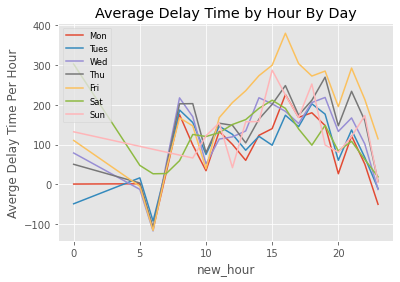

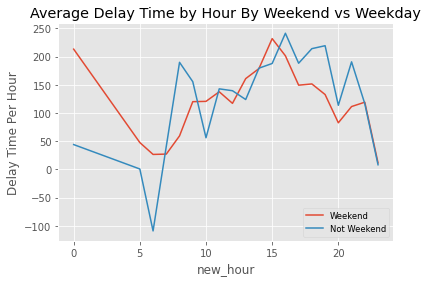

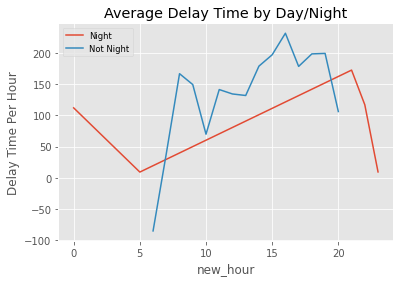

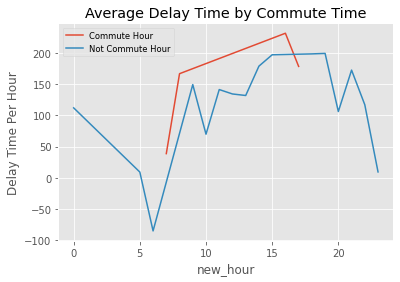

In [33]:
chart_by_timefeatures(df=route_pd_df,target_feature='delay_amount')

## Drop Columns which are non-Informative

In [34]:
route_pd_df.drop(['new_minute','new_year'],axis=1,inplace=True)

## Create a Correlation Matrix before Weather or Heatmap is Added

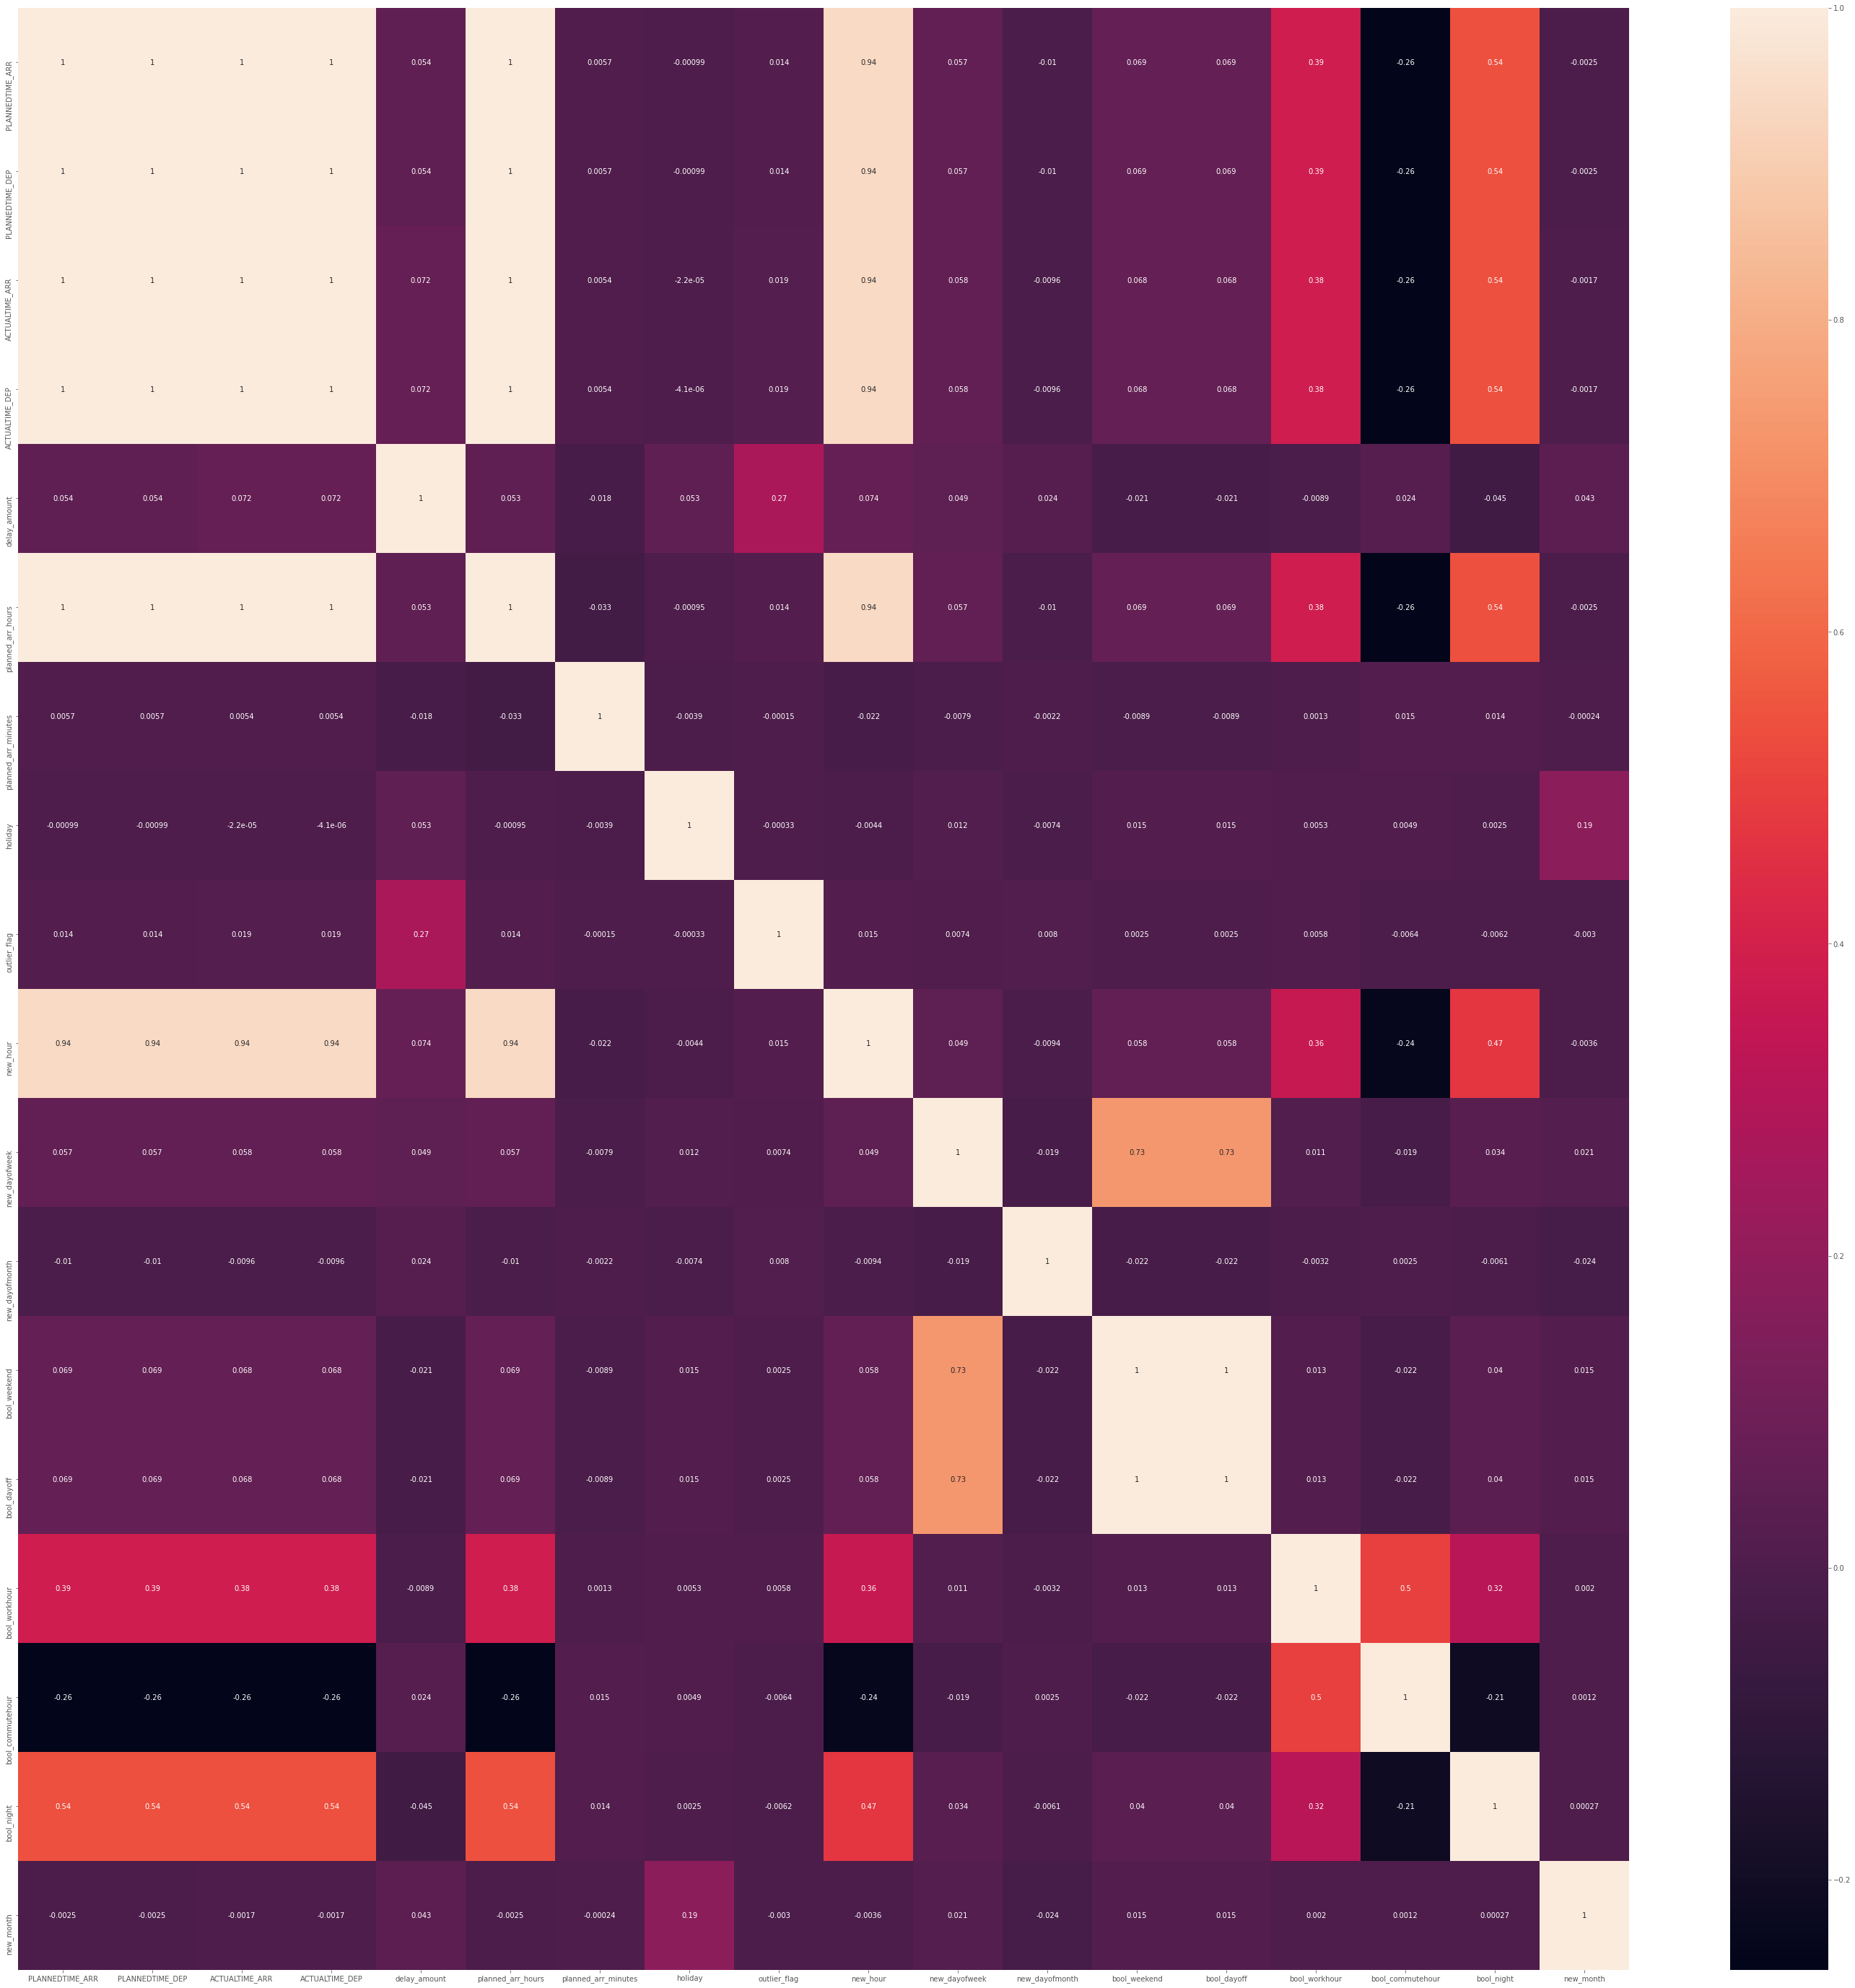

In [35]:
train_correlation_df=create_correlation_heatmap(df=route_pd_df
                                                ,pdf_fn='./1_Correlation_Heatmap_NoWeather.pdf'
                                                ,savefig=True)

## Add on Route Header Data

In [36]:
route_pd_df

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,...,outlier_flag,new_hour,new_dayofweek,new_dayofmonth,bool_weekend,bool_dayoff,bool_workhour,bool_commutehour,bool_night,new_month
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,...,0.0,21,0,1,False,False,True,False,True,1
1,2018-01-01,5968222,2,935,82843,82843,82844,82844,2534829,NaN,...,0.0,23,0,1,False,False,True,False,True,1
2,2018-01-01,5957733,2,935,84643,84643,84643,84643,2868314,NaN,...,0.0,23,0,1,False,False,True,False,True,1
3,2018-01-01,5968214,1,4381,42300,42300,42326,42326,1001151,NaN,...,0.0,11,0,1,False,False,False,False,False,1
4,2018-01-01,5957726,1,4381,48300,48300,48298,48298,1000198,NaN,...,0.0,13,0,1,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998734,2018-12-01,8148340,7,6033,21090,21090,21131,21131,1000195,NaN,...,0.0,5,5,1,True,True,True,False,True,12
998735,2018-12-01,8148340,19,1041,21556,21556,21499,21499,1000195,NaN,...,0.0,5,5,1,True,True,True,False,True,12
998736,2018-12-01,8148340,31,3586,22185,22185,22169,22169,1000195,NaN,...,0.0,6,5,1,True,True,True,False,False,12
998737,2018-12-01,8148340,43,3598,22710,22710,22700,22700,1000195,NaN,...,0.0,6,5,1,True,True,True,False,False,12


In [38]:
merged_df=join_trip_to_route_df(df=route_pd_df,trip_fp="./data/rt_trips_DB_2018.txt",trip_sep=';')
display(merged_df)
print("""Does the row count match: {} = {}? {}""".format(len(route_pd_df),len(merged_df),len(route_pd_df)==len(merged_df)))

DATASOURCE                 object
DAYOFSERVICE       datetime64[ns]
TRIPID                     object
LINEID                   category
ROUTEID                  category
DIRECTION                category
PLANNEDTIME_ARR             int64
PLANNEDTIME_DEP             int64
ACTUALTIME_ARR            float64
ACTUALTIME_DEP            float64
BASIN                      object
TENDERLOT                 float64
SUPPRESSED                float64
JUSTIFICATIONID           float64
LASTUPDATE                 object
NOTE                       object
dtype: object


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,...,new_dayofmonth,bool_weekend,bool_dayoff,bool_workhour,bool_commutehour,bool_night,new_month,LINEID,ROUTEID,DIRECTION
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,...,1,False,False,True,False,True,1,102,102_8,1
1,2018-01-01,5957731,1,4381,77700,77700,77683,77683,2868314,NaN,...,1,False,False,True,False,True,1,102,102_8,1
2,2018-01-01,5957731,3,936,77765,77765,77727,77727,2868314,NaN,...,1,False,False,True,False,True,1,102,102_8,1
3,2018-01-01,5957731,5,914,77854,77854,77805,77805,2868314,NaN,...,1,False,False,True,False,True,1,102,102_8,1
4,2018-01-01,5957731,6,938,77886,77886,77830,77830,2868314,NaN,...,1,False,False,True,False,True,1,102,102_8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998734,2018-12-01,8135583,42,3609,57436,57436,57457,57464,1001155,NaN,...,1,True,True,False,False,False,12,102,102_9,2
998735,2018-12-01,8135583,52,952,57899,57899,57933,57933,1001155,NaN,...,1,True,True,True,True,False,12,102,102_9,2
998736,2018-12-01,8135583,5,3078,54901,54901,54961,54961,1001155,NaN,...,1,True,True,False,False,False,12,102,102_9,2
998737,2018-12-01,8135583,15,4925,55419,55419,55520,55520,1001155,NaN,...,1,True,True,False,False,False,12,102,102_9,2


Does the row count match: 998739 = 998739? True


## Add on Weather Data

Remove Duplicates which are introduced from the time change.

In [39]:
total_df=join_weather_to_route_df(route_df=merged_df,weather_df=weather_df)
total_df=total_df.drop_duplicates(["TRIPID", "datetime_exact"])

                      dt                         dt_iso timezone    temp  \
0    2017-12-31 00:00:00  2017-12-31 00:00:00 +0000 UTC        0  283.06   
1    2017-12-31 01:00:00  2017-12-31 01:00:00 +0000 UTC        0  284.24   
2    2017-12-31 02:00:00  2017-12-31 02:00:00 +0000 UTC        0  284.16   
3    2017-12-31 03:00:00  2017-12-31 03:00:00 +0000 UTC        0  283.14   
4    2017-12-31 04:00:00  2017-12-31 04:00:00 +0000 UTC        0  281.75   
...                  ...                            ...      ...     ...   
8843 2019-01-01 19:00:00  2019-01-01 19:00:00 +0000 UTC        0  279.47   
8844 2019-01-01 20:00:00  2019-01-01 20:00:00 +0000 UTC        0  279.21   
8845 2019-01-01 21:00:00  2019-01-01 21:00:00 +0000 UTC        0  278.05   
8846 2019-01-01 22:00:00  2019-01-01 22:00:00 +0000 UTC        0  277.36   
8847 2019-01-01 23:00:00  2019-01-01 23:00:00 +0000 UTC        0  276.46   

      feels_like  temp_min  temp_max  pressure  humidity  wind_speed  \
0         279.5

,dt,dt_iso,timezone,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,new_dayofweek,new_dayofmonth,bool_weekend,bool_dayoff,bool_workhour,bool_commutehour,bool_night,new_month,new_year,new_minute
24,2018-01-01 00:00:00,2018-01-01 00:00:00 +0000 UTC,0,277.30,266.66,276.993,278.939,990,87,12.86,...,0,1,False,False,True,False,True,1,2018,0
25,2018-01-01 01:00:00,2018-01-01 01:00:00 +0000 UTC,0,277.29,267.36,276.797,279.014,991,87,11.83,...,0,1,False,False,True,False,True,1,2018,0
26,2018-01-01 02:00:00,2018-01-01 02:00:00 +0000 UTC,0,277.76,267.38,277.003,279.140,990,81,12.35,...,0,1,False,False,True,False,True,1,2018,0
27,2018-01-01 03:00:00,2018-01-01 03:00:00 +0000 UTC,0,277.79,267.42,277.150,279.288,990,81,12.35,...,0,1,False,False,True,False,True,1,2018,0
28,2018-01-01 04:00:00,2018-01-01 04:00:00 +0000 UTC,0,278.19,268.24,277.262,279.367,990,81,11.83,...,0,1,False,False,True,False,True,1,2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8819,2018-12-31 19:00:00,2018-12-31 19:00:00 +0000 UTC,0,282.80,278.93,281.184,283.150,1034,76,4.10,...,0,31,False,False,True,False,False,12,2018,0
8820,2018-12-31 20:00:00,2018-12-31 20:00:00 +0000 UTC,0,282.42,278.67,281.369,283.150,1034,81,4.10,...,0,31,False,False,True,False,False,12,2018,0
8821,2018-12-31 21:00:00,2018-12-31 21:00:00 +0000 UTC,0,282.46,278.02,281.480,283.150,1034,81,5.10,...,0,31,False,False,True,False,True,12,2018,0
8822,2018-12-31 22:00:00,2018-12-31 22:00:00 +0000 UTC,0,282.34,277.45,281.480,283.150,1035,81,5.70,...,0,31,False,False,True,False,True,12,2018,0


Index(['dt', 'dt_iso', 'timezone', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'snow_1h', 'clouds_all', 'weather_id', 'weather_main',
       'weather_description', 'weather_icon', 'new_hour', 'new_dayofweek',
       'new_dayofmonth', 'bool_weekend', 'bool_dayoff', 'bool_workhour',
       'bool_commutehour', 'bool_night', 'new_month', 'new_year',
       'new_minute'],
      dtype='object')


## Correlation with Weather Data

And all added

In [40]:
correlation_columns=['DAYOFSERVICE'
     , 'TRIPID'
     , 'PROGRNUMBER'
     , 'STOPPOINTID'
     , 'PLANNEDTIME_ARR'
     , 'PLANNEDTIME_DEP'
     , 'ACTUALTIME_ARR'
     , 'ACTUALTIME_DEP'
     , 'VEHICLEID'
     , 'SUPPRESSED'
     , 'JUSTIFICATIONID'
     , 'LASTUPDATE'
     , 'date_and_time'
     , 'datetime_exact'
     , 'delay_amount'
     , 'planned_arr_hours'
     , 'planned_arr_minutes'
     , 'day_of_week'
     , 'holiday'
     , 'outlier_flag'
     , 'new_hour'
     , 'new_dayofweek_x'
     , 'new_dayofmonth'
     , 'bool_weekend_x'
     , 'bool_dayoff_x'
     , 'bool_workhour_x'
     , 'bool_commutehour_x'
     , 'bool_night_x'
     , 'new_month'
     , 'LINEID'
     , 'ROUTEID'
     , 'DIRECTION'
     , 'dt'
     , 'dt_iso'
     , 'timezone'
     , 'temp'
     , 'feels_like'
     , 'temp_min'
     , 'temp_max'
     , 'pressure'
     , 'humidity'
     , 'wind_speed'
     , 'wind_deg'
     , 'rain_1h'
     , 'snow_1h'
     , 'clouds_all'
     , 'weather_id'
     , 'weather_main'
     , 'weather_description'
     , 'weather_icon']

total_df=total_df[correlation_columns]

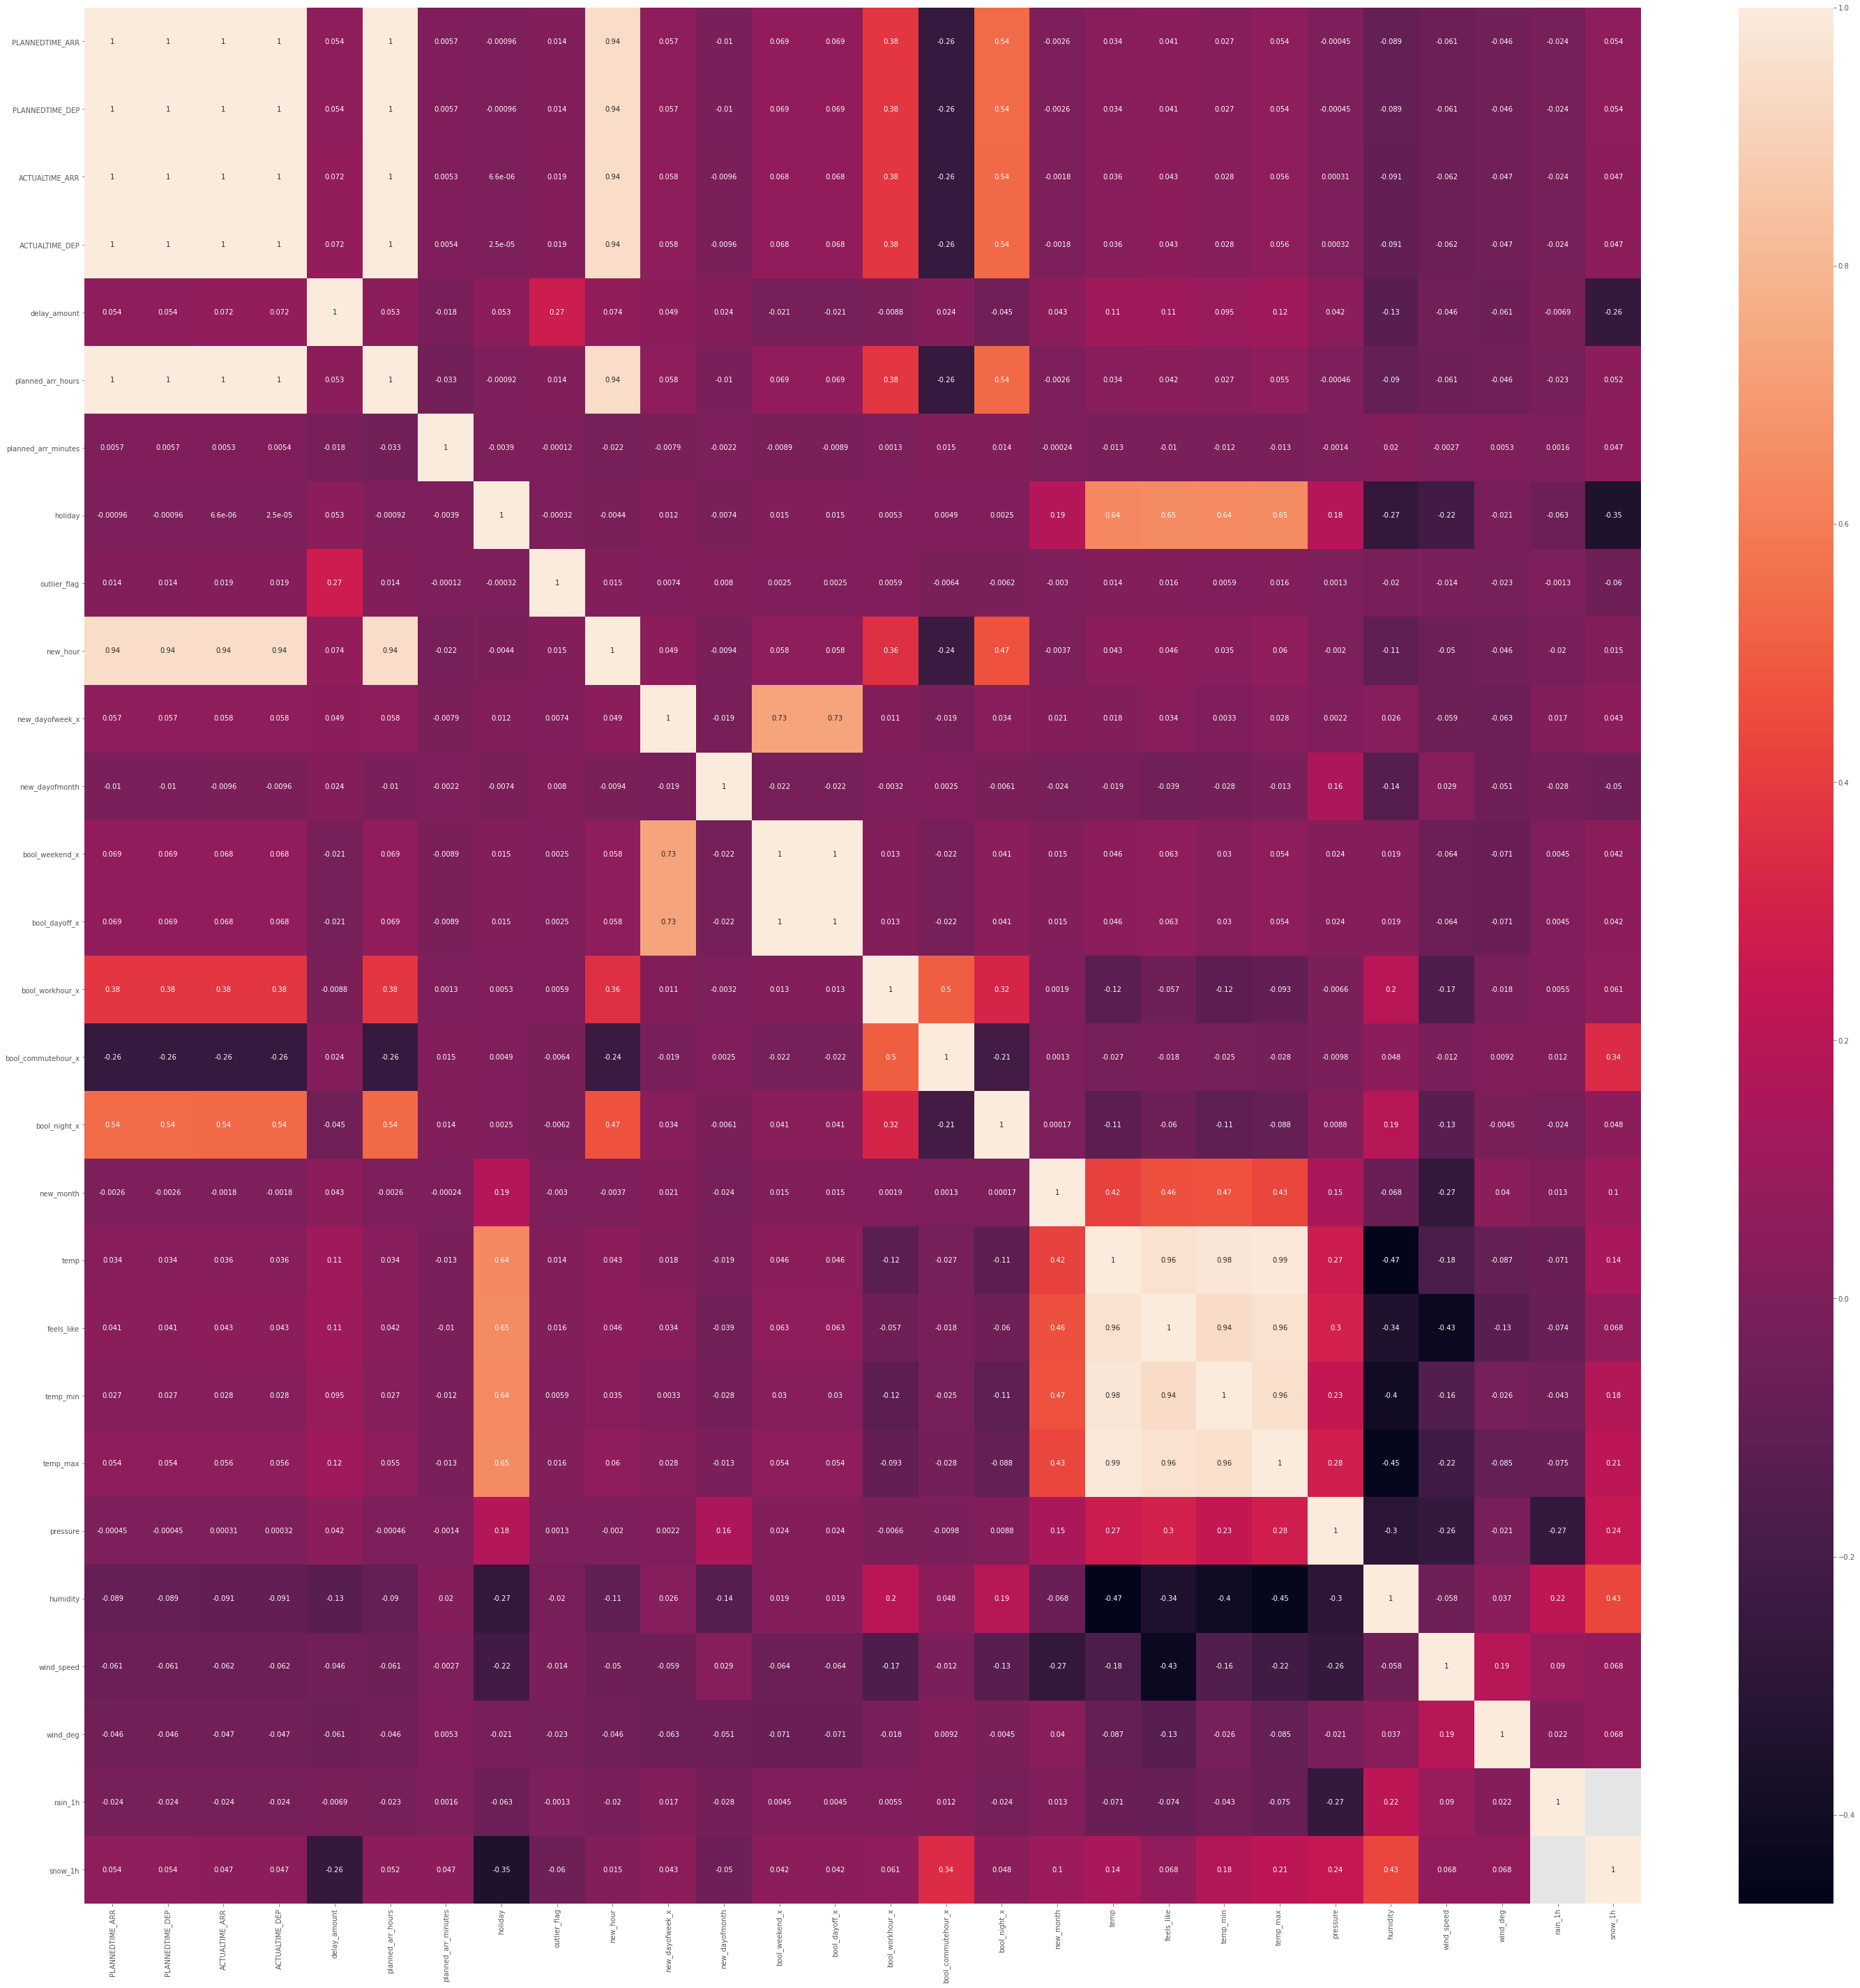

In [41]:
total_train_correlation_df=create_correlation_heatmap(df=total_df
                                                ,pdf_fn='./2_Correlation_Heatmap_All_inc_Weather.pdf'
                                                ,savefig=True)

## Most Strongly Correlated items

In [42]:
total_train_correlation_df['delay_amount'].sort_values(ascending=False)

delay_amount           1.000000
outlier_flag           0.273012
temp_max               0.115209
temp                   0.112203
feels_like             0.107626
temp_min               0.094979
new_hour               0.074213
ACTUALTIME_DEP         0.071919
ACTUALTIME_ARR         0.071849
PLANNEDTIME_DEP        0.053719
PLANNEDTIME_ARR        0.053719
holiday                0.053052
planned_arr_hours      0.052876
new_dayofweek_x        0.049142
new_month              0.042794
pressure               0.041956
new_dayofmonth         0.023931
bool_commutehour_x     0.023823
rain_1h               -0.006918
bool_workhour_x       -0.008839
planned_arr_minutes   -0.018444
bool_dayoff_x         -0.021399
bool_weekend_x        -0.021399
bool_night_x          -0.044720
wind_speed            -0.046217
wind_deg              -0.060803
humidity              -0.125376
snow_1h               -0.263861
Name: delay_amount, dtype: float64

## Removed Outliers

In [43]:
full_df=total_df[total_df['outlier_flag']==0]
full_df.to_pickle("./data/route102_full_df.pickle")

In [55]:
temp_features_selected=["DAYOFSERVICE","PROGRNUMBER","DIRECTION", "planned_arr_hours", "planned_arr_minutes", "holiday", "humidity", 'rain_1h','weather_id','delay_amount']

In [56]:
full_model_df=full_df[temp_features_selected]

In [57]:
test_train_dict=get_randomised_data(df=full_model_df,time_column='DAYOFSERVICE',test_size=0.3,random=False)
test_df=test_train_dict['Test']
train_df=test_train_dict['Train']

temp_features_selected.remove('DAYOFSERVICE')

features_selected=temp_features_selected

full_model_df=full_model_df[features_selected]
test_df=test_df[features_selected]
train_df=train_df[features_selected]

Total dates: 333
Test dates: 99.89999999999999
Test index: 233
Total dates: 333
Test dates: 99.89999999999999
Test index: 233
Dates after 2018-08-24T00:00:00.000000000 are test dates


In [58]:
xfull_model_df=full_model_df
xtest_df=test_df
xtrain_df=train_df

xfull_model_df['PROGRNUMBER']=xfull_model_df['PROGRNUMBER'].astype(int)
xfull_model_df['DIRECTION']=xfull_model_df['DIRECTION'].astype(int)
xfull_model_df['weather_id']=xfull_model_df['weather_id'].astype(int)


xtest_df['PROGRNUMBER']=xtest_df['PROGRNUMBER'].astype(int)
xtest_df['DIRECTION']=xtest_df['DIRECTION'].astype(int)
xtest_df['weather_id']=xtest_df['weather_id'].astype(int)


xtrain_df['PROGRNUMBER']=xtrain_df['PROGRNUMBER'].astype(int)
xtrain_df['DIRECTION']=xtrain_df['DIRECTION'].astype(int)
xtrain_df['weather_id']=xtrain_df['weather_id'].astype(int)

<ipython-input-58-d9ba4beba5b2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest_df['PROGRNUMBER']=xtest_df['PROGRNUMBER'].astype(int)
<ipython-input-58-d9ba4beba5b2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest_df['DIRECTION']=xtest_df['DIRECTION'].astype(int)
<ipython-input-58-d9ba4beba5b2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [59]:
full_model_df.dtypes

PROGRNUMBER              int64
DIRECTION                int64
planned_arr_hours        int64
planned_arr_minutes      int64
holiday                  int64
humidity                 int64
rain_1h                float64
weather_id               int64
delay_amount             int64
dtype: object

delay_amount = 
('PROGRNUMBER' * 3.3583563659163076)
+('DIRECTION' * 20.824355452862612)
+('planned_arr_hours' * 0.32054544995852474)
+('planned_arr_minutes' * -0.5105997508831237)
+('holiday' * 9.329149188589112)
+('humidity' * -2.0235762370622368)
+('rain_1h' * 19.494884275377974)
+('weather_id' * -0.0869459011111644) + (249.4984616606318)




---------------
---------------
As part of 3 we are meant to predict the data used to train the model (???)
The Original Test Vs Predicted Result for Test Set Is:


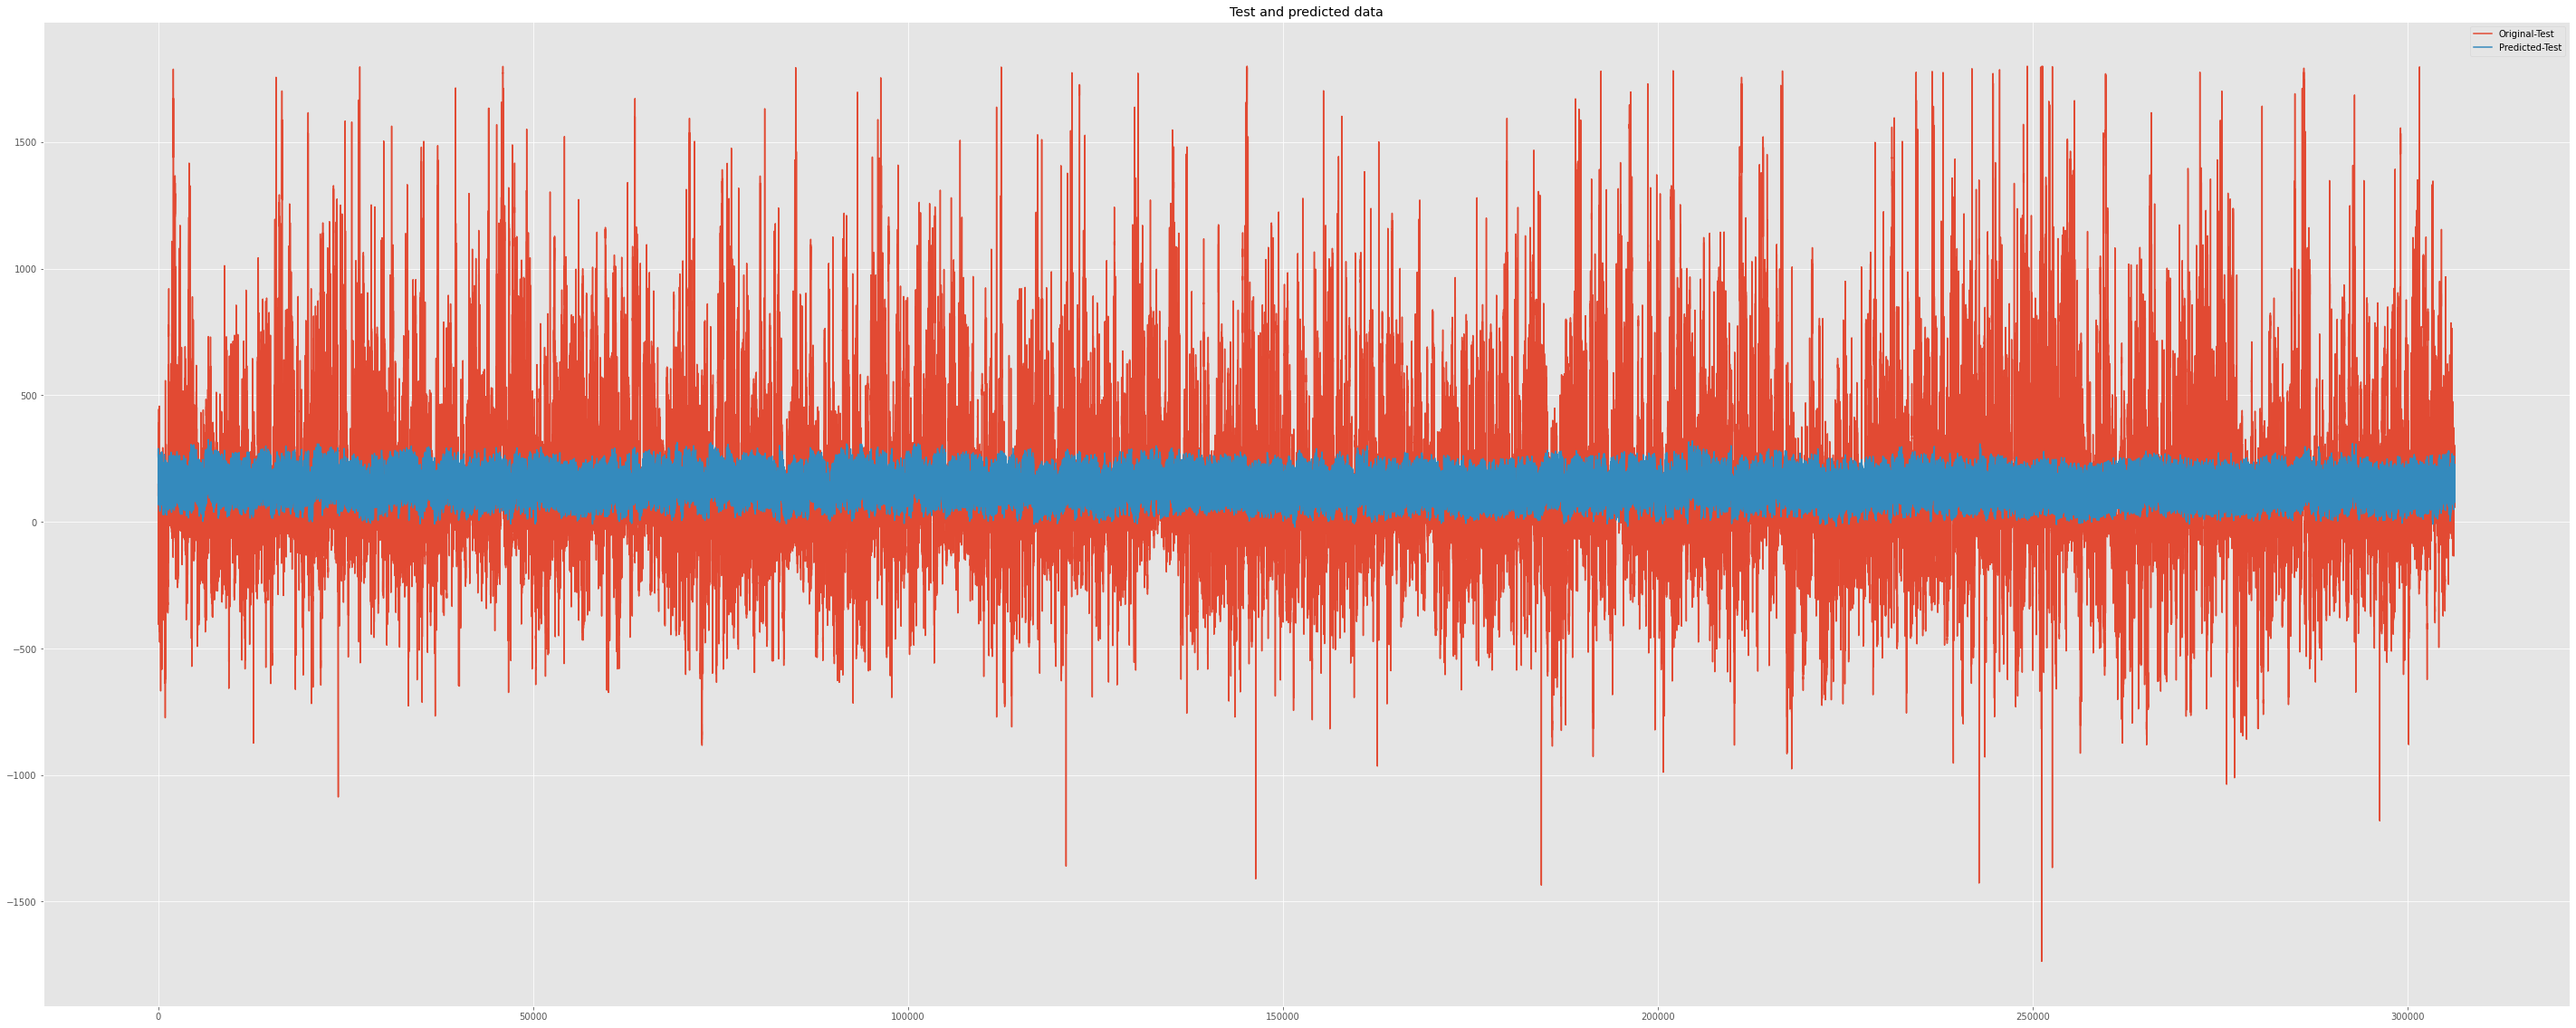

As required the First Ten Results predicting for the training data:


,Actual,Predicted,PredictionClass,Diff
690550,148,262.474252,262.474252,-114.474252
690551,144,265.832609,265.832609,-121.832609
690552,134,268.680365,268.680365,-134.680365
690553,131,272.038722,272.038722,-141.038722
690554,131,274.886478,274.886478,-143.886478
690555,142,280.581992,280.581992,-138.581992
690556,102,286.788105,286.788105,-184.788105
690557,118,289.635861,289.635861,-171.635861
690558,106,253.610437,253.610437,-147.610437
690559,134,277.734235,277.734235,-143.734235


----REPORT----
MAE:  212.10158283595405
MSE:  88518.62112779012
RMSE:  297.5207910849091
R2:  0.03685781061253979
----DETAIL----


Accuracy: 
 None


Confusion matrix: 
 None


Classification report:
  None
---------------
---------------
---------------
---------------
 PROPER RESULT FROM TEST DATA:
The Original Vs Predicted Result Is:


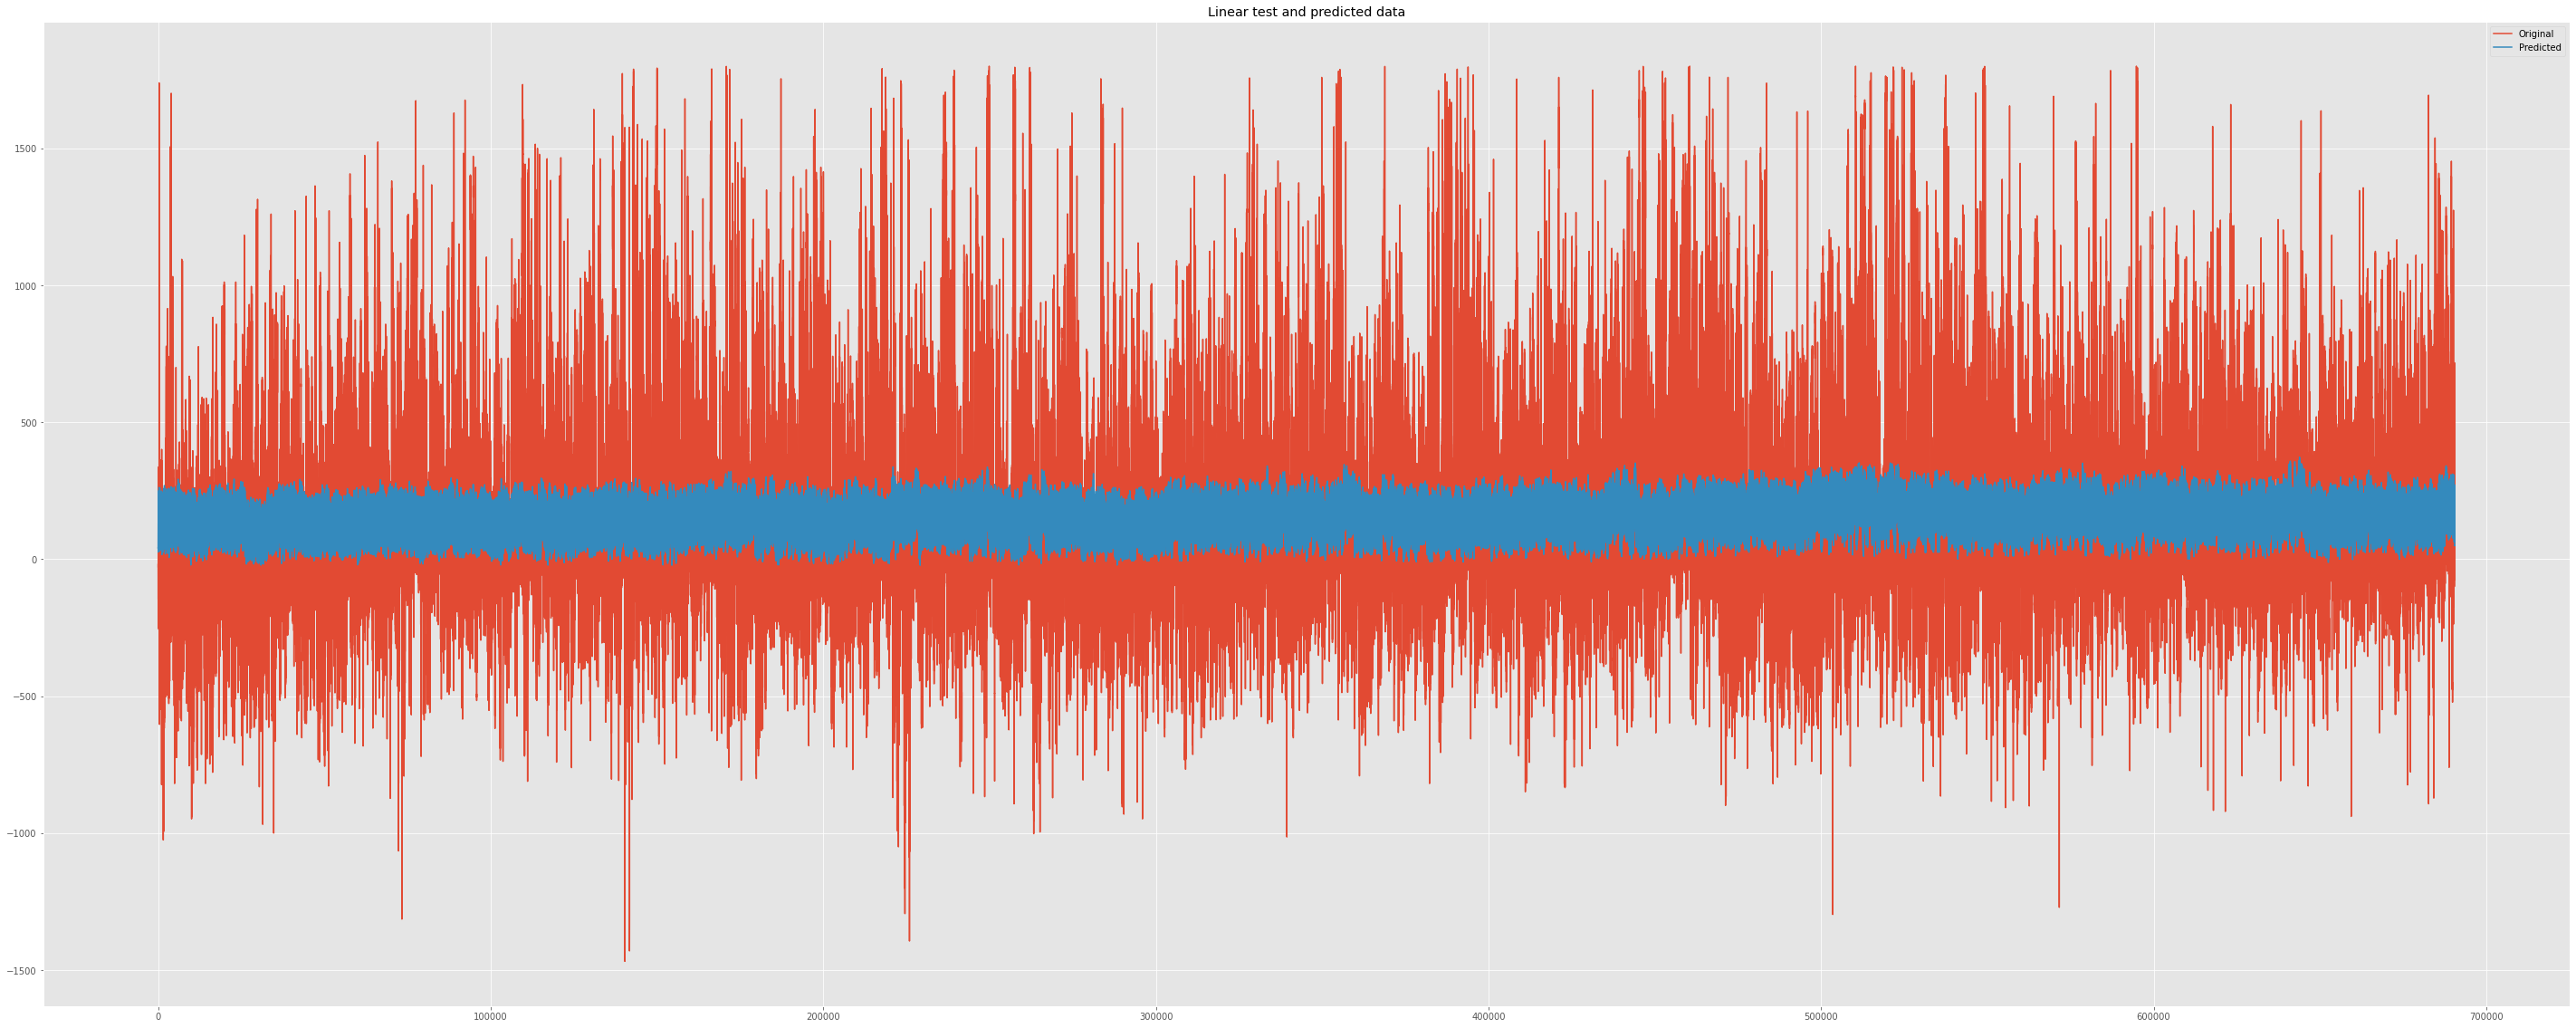

----REPORT----
MAE:  209.83492310120155
MSE:  87127.33942067843
RMSE:  295.1734056799129
R2:  0.04992915932977049
----DETAIL----


Accuracy: 
 None


Confusion matrix: 
 None


Classification report:
  None
[82457.89631576 94517.52974348 97155.36241021 71760.25907856
 92145.30468163]
Avg RMSE score over 5 folds: 
 295.54498362702844
Stddev RMSE score over 5 folds: 
 16.137939732987086


In [60]:
linreg_class_rep=create_model(fulldf=full_model_df,train_df=train_df,test_df=test_df,target_column='delay_amount',plot_comp=True, threshhold_class=0.5, assess=True, verbose=True,mod_type='Linear')

---------------
---------------
As part of 3 we are meant to predict the data used to train the model (???)
The Original Test Vs Predicted Result for Test Set Is:


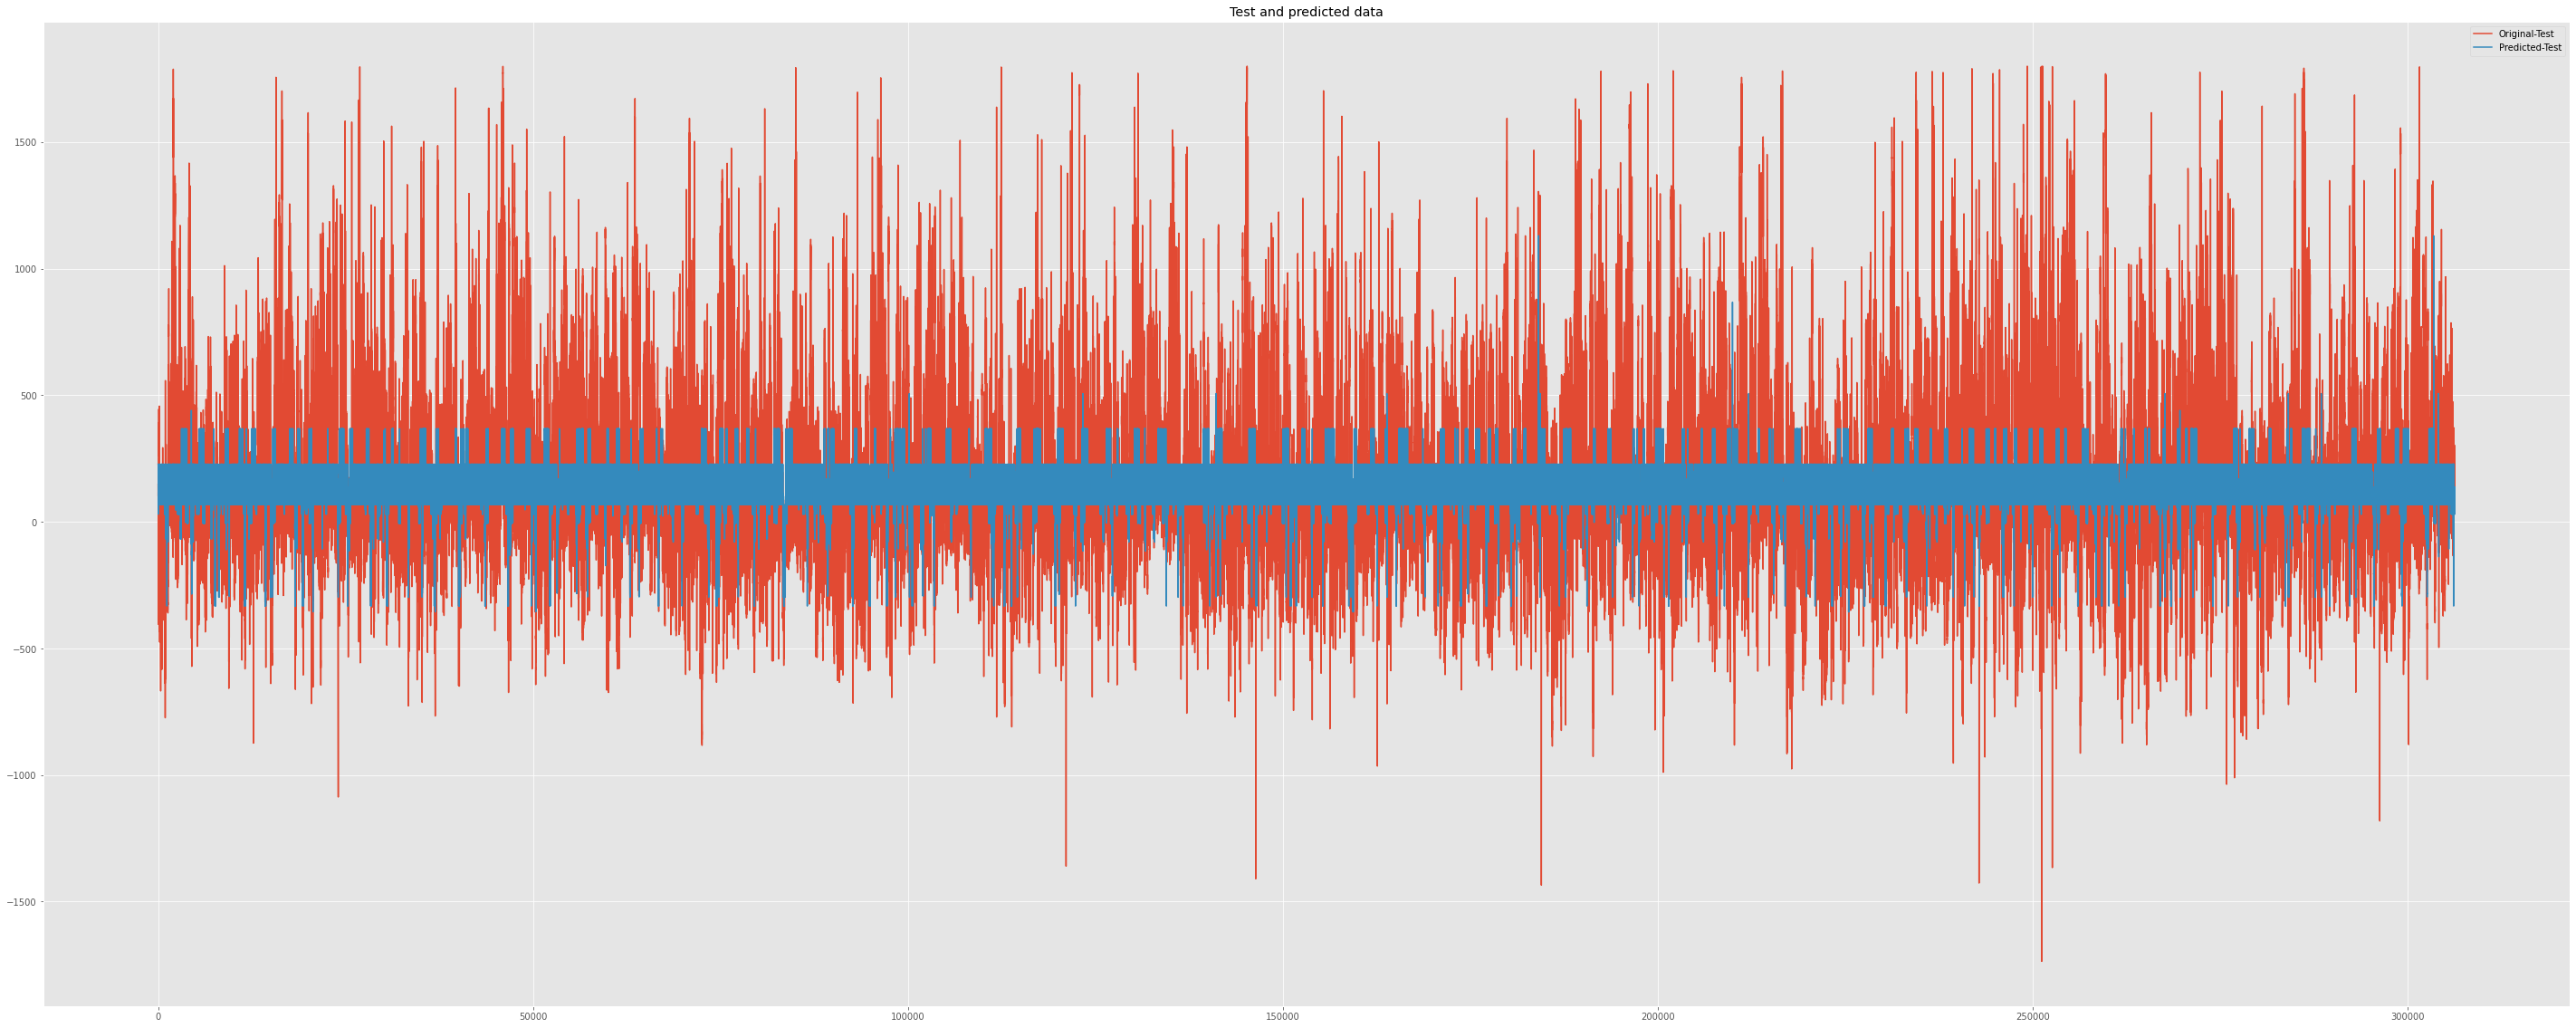

As required the First Ten Results predicting for the training data:


,Actual,Predicted,PredictionClass,Diff
690550,148,227.564823,227.564823,-79.564823
690551,144,227.564823,227.564823,-83.564823
690552,134,227.564823,227.564823,-93.564823
690553,131,227.564823,227.564823,-96.564823
690554,131,227.564823,227.564823,-96.564823
690555,142,227.564823,227.564823,-85.564823
690556,102,227.564823,227.564823,-125.564823
690557,118,227.564823,227.564823,-109.564823
690558,106,227.564823,227.564823,-121.564823
690559,134,227.564823,227.564823,-93.564823


----REPORT----
MAE:  204.24034296736278
MSE:  83080.3829683873
RMSE:  288.23667873535334
R2:  0.09602950285677503
----DETAIL----


Accuracy: 
 None


Confusion matrix: 
 None


Classification report:
  None
---------------
---------------
---------------
---------------
 PROPER RESULT FROM TEST DATA:
Random Forest: The Original Vs Predicted Result Is:


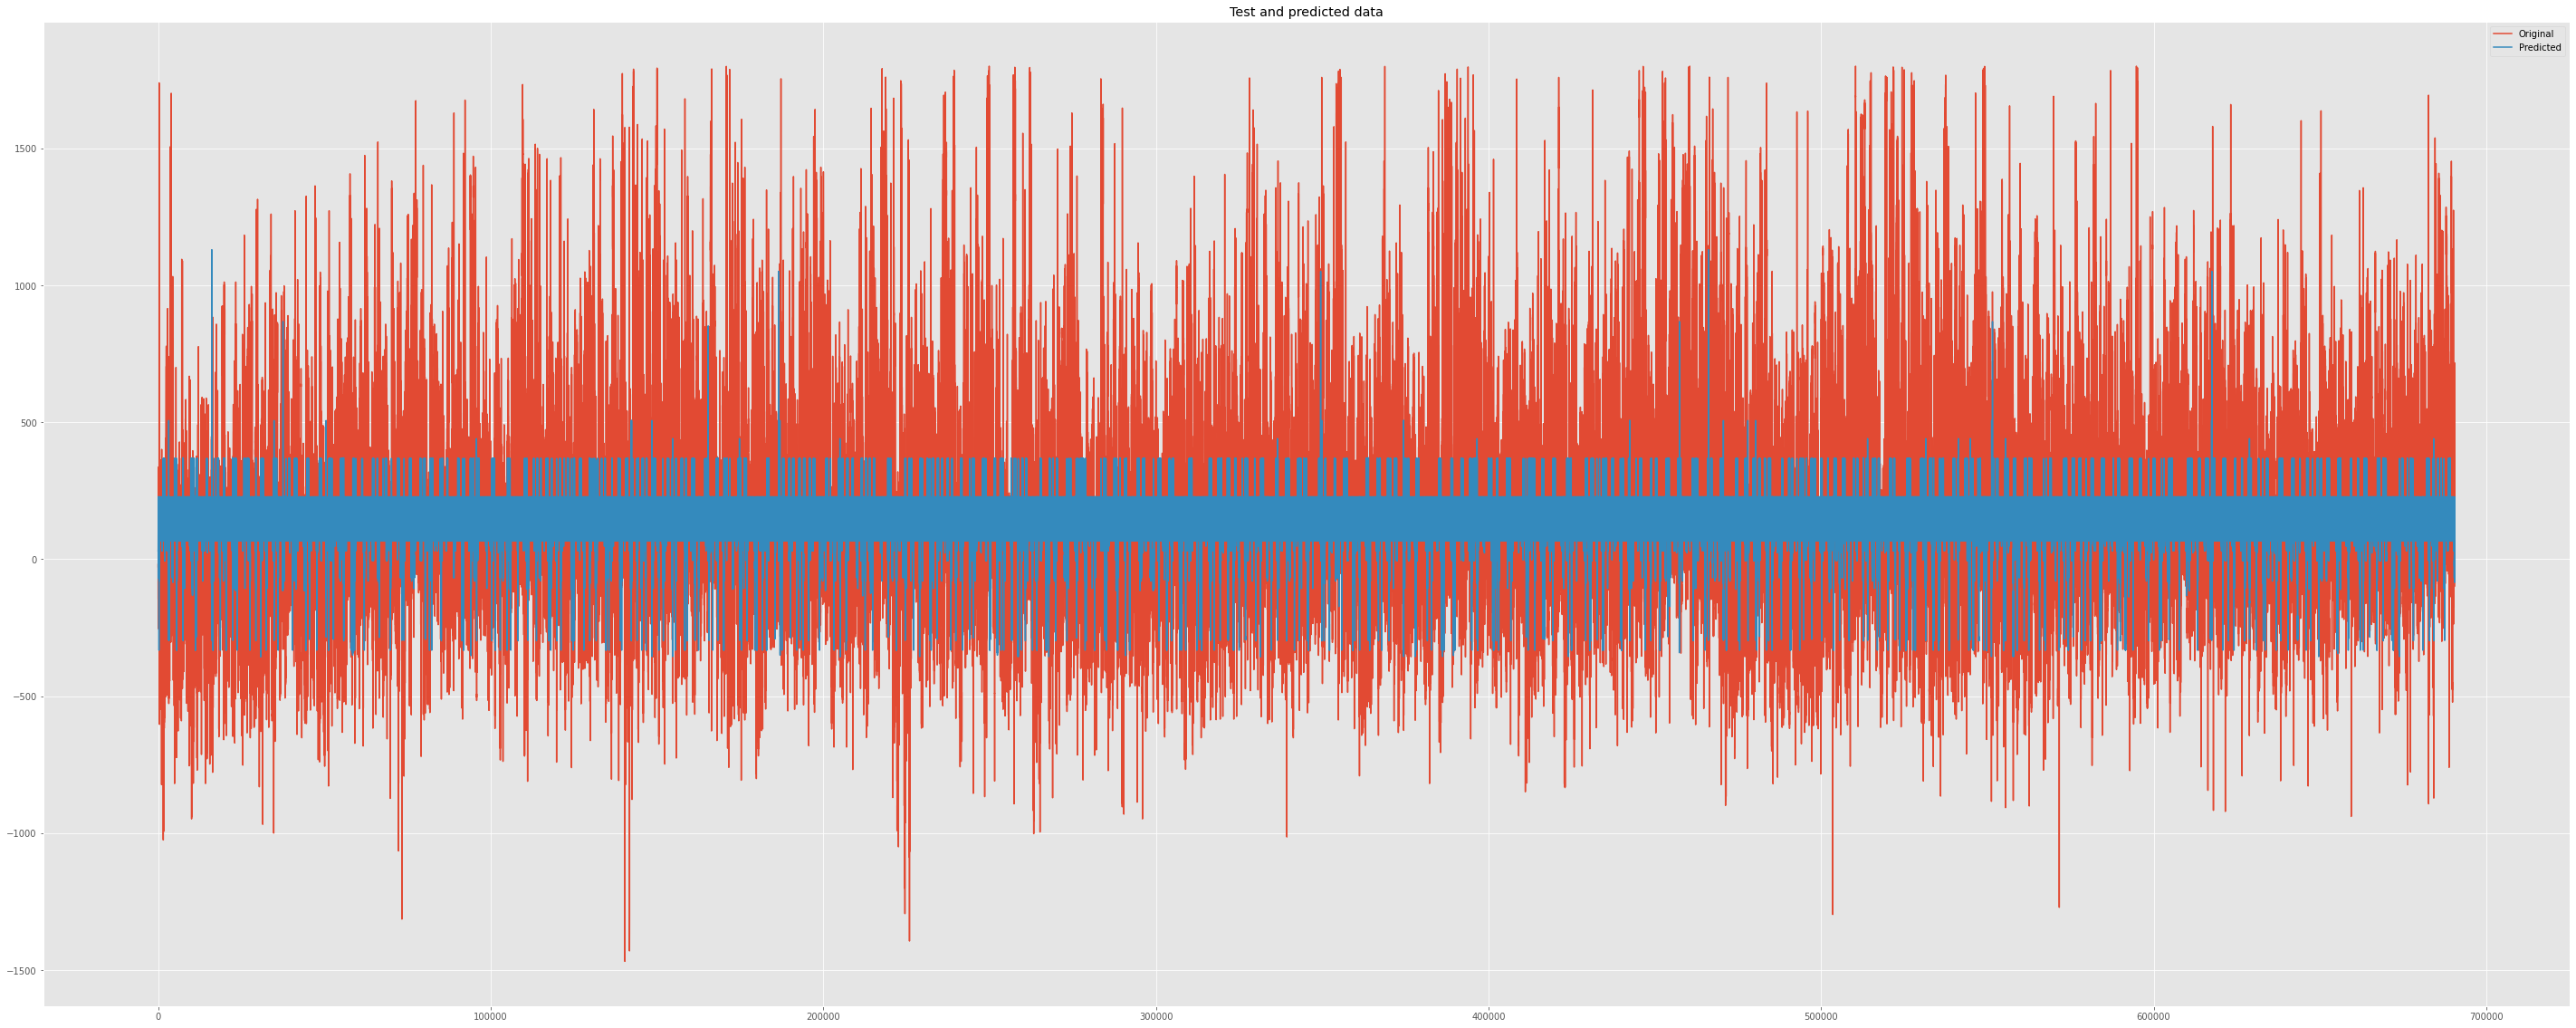

Random Forest: Feature Importance:


<Figure size 3600x1440 with 0 Axes>

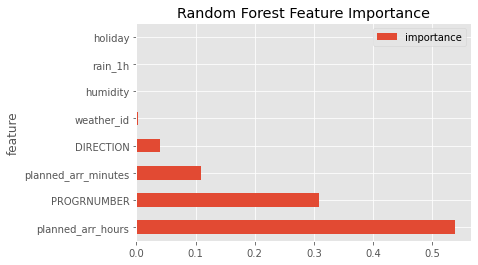

----REPORT----
MAE:  205.39892288597443
MSE:  85064.59595702664
RMSE:  291.65835485551696
R2:  0.07242212686016125
----DETAIL----


Accuracy: 
 None


Confusion matrix: 
 None


Classification report:
  None


/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/team10/miniconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterato

/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/team10/miniconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/team10/miniconda3/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/team10/miniconda3/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
 

[nan nan nan nan nan]
Avg Accuracy score over 5 folds: 
 nan
Stddev Accuracy score over 5 folds: 
 nan


/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/team10/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/team10/miniconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/team10/miniconda3/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/team10/miniconda3/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
 

In [61]:
rf_class_rep=create_model(fulldf=full_model_df,train_df=train_df,test_df=test_df,target_column='delay_amount',plot_comp=True, threshhold_class=0.5, assess=True, verbose=True,mod_type='Random Forest')

In [ ]:
xgb_class_rep=create_model(fulldf=xfull_model_df,train_df=xtrain_df,test_df=xtest_df,target_column='delay_amount',plot_comp=True, threshhold_class=0.5, assess=True, verbose=True,mod_type='XGBoost')

In [ ]:
model_class_dictionary={
    'Linear':linreg_class
    ,'RandomForest':rf_class
    ,'XGBoost':''
}

In [ ]:
result_df=regression_compare_models(model_class_dictionary,keys=["Linear","RandomForest","XGBoost"])